In [1]:
from DataLoader import H5DataLoader
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import os
import sys
import matplotlib.pyplot as plt
import librosa
import librosa.display
import matplotlib.cm as cm
from matplotlib.colors import Normalize

/home/nico/.venv/lib/python3.12/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# Data Cleaning
## Loading Data from File

In [2]:
def get_file_path(identifier, person):
    data_dir = '../data/'
    # Available files
    files = os.listdir(data_dir)

    # Define the files to ignore
    files_to_ignore = ['Icon\r']

    filtered_files = [file for file in files if file not in files_to_ignore]
    print(filtered_files)
    
    # Make the search case-insensitive
    person = person.lower()
    identifier = identifier.lower()
    
    # Search for matching file
    for file in files:
        file_lower = file.lower()
        if identifier.lower() in file_lower and person.lower() in file_lower:
            print("found " + data_dir + file)
            return data_dir + file
    
    # If no match is found, return a descriptive message
    error_message = f"No recording found for identifier '{identifier}' and person '{person}'"
    print(error_message)
    return None


AUDIO_SAMPLE_RATE  =  48000 #Hz
ADC_SAMPLE_RATE    =   8000 #Hz


In [3]:
PERSON = 'PhonemeStory'
IDENTIFIER = 'Sam'
DATASET_PATH = get_file_path(IDENTIFIER, PERSON)

['p2SamRecoring.h5', 'p2Jackecording.h5', 'p3SamRecordings.h5', 'WhisperStory.h5', 'p1SamRecording.h5', 'WhisperSam.h5', 'Samrecordings.h5', 'SamPhonemeStory.h5', 'p3JackRecording.h5', 'p2SamPhonemes.h5']
found ../data/SamPhonemeStory.h5


In [4]:
loader = H5DataLoader(DATASET_PATH)
datasets = loader.list_datasets()
print("Available datasets:", datasets)


# Check data
evaldata = loader.load_dataset(datasets[0])
print("Eval Audio :", len(evaldata["audio_data"]))
print("Eval ADC channels:", evaldata["adc_data"].keys())
print("Eval ADC ch 1:", evaldata["adc_data"][1].shape)
print("Eval ADC ch 3 :", evaldata["adc_data"][3].shape)

N_audio_samples = len(evaldata["audio_data"])
N_adc_samples = len(evaldata["adc_data"][1]) + len(evaldata["adc_data"][3])
print("Eval Audio samples:", N_audio_samples)
print("Eval ADC samples:", N_adc_samples)
ratio = N_audio_samples / N_adc_samples
print("Audio to ADC ratio:", ratio)
expected_ratio = AUDIO_SAMPLE_RATE / ADC_SAMPLE_RATE
print("Expected ratio:", expected_ratio)

Available datasets: ['story1', 'story1slow', 'story2', 'story2slow', 'story3', 'story3slow']
Eval Audio : 2650624
Eval ADC channels: dict_keys([1, 3])
Eval ADC ch 1: (221184,)
Eval ADC ch 3 : (221184,)
Eval Audio samples: 2650624
Eval ADC samples: 442368
Audio to ADC ratio: 5.991898148148148
Expected ratio: 6.0


In [6]:
!pip install openai-whisper

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.5/800.5 kB 34.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 76.5 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20240930-py3-none-any.whl size=803405 sha256=89b2afa572792bc36cc103ac4084a4736b2348e71a99bfecbe3dca00bca6356b
  Stored in directory: /home/nico/.cache/pip/wheels/7c/f5/6f/92094c35416f9397abb86b23cfe72fb255a3013012f983136d
Successfully built openai-whisper


In [8]:
import whisper
import tempfile
import soundfile as sf
import string

datasets = loader.list_datasets()
print("Available datasets:", datasets)

# Load the Whisper model (you can choose a different size like "small", "medium", etc.)
model = whisper.load_model("base")

# Dictionary to store unique word counts per dataset
unique_words_count = {}

# Iterate over each dataset
for ds in datasets:
    print(f"\nProcessing dataset: {ds}")
    data = loader.load_dataset(ds)
    audio_data = data["audio_data"]  # Assuming this is a 1-D numpy array or list of samples

    # Save the audio data to a temporary WAV file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        tmp_file = tmp.name
        sf.write(tmp_file, audio_data, AUDIO_SAMPLE_RATE)

    # Use Whisper to transcribe the temporary audio file
    result = model.transcribe(tmp_file)
    transcription = result["text"]
    print(f"Transcription for dataset {ds}:\n{transcription}")

    # Clean the transcription: remove punctuation and convert to lower case
    translator = str.maketrans("", "", string.punctuation)
    cleaned_text = transcription.translate(translator).lower()
    words = cleaned_text.split()
    unique_words = set(words)
    count_unique = len(unique_words)

    unique_words_count[ds] = count_unique
    print(f"Dataset {ds} has {count_unique} unique words.")

print("\nUnique words count for all datasets:")
for ds, count in unique_words_count.items():
    print(f"  {ds}: {count}")


Available datasets: ['story1', 'story1slow', 'story2', 'story2slow', 'story3', 'story3slow']

Processing dataset: story1
Transcription for dataset story1:
 On a sunny day in May, an ace pilot named Sue looked out over the same landscape with the deep sigh. Her moose companion gave a soft moose as she adjusted the seam of her shoe placed in a key in her pocket alongside a dime. Why must they seek to aid me in my doom, she wondered? Watching Ray, his, her stride dude friend, come up the rocky path. The seed of doubt took root on her side as she tried to wake from what felt like a nightmare. One she couldn't wash away. Sue decided to make her way to the cabin, where a vase of weed flowers sat beside a bottle of rum. She could shock them with her bold plan or shave seconds off of her escape if she moved quickly enough. Will me all you want, she muttered, looking at us with determination, but I won't be the same afters day. The moose nudged her hand as if to say even in doom they might find

In [ ]:
# Install with: pip install phonemizer
from phonemizer import phonemize

text = "This is a test sentence."
phonemes = phonemize(
    text, 
    language='en-us', 
    backend='espeak',  # You can choose 'espeak', 'espeak-ng', etc.
    strip=True
)
print(phonemes)


ðɪs ɪz ɐ tɛst sɛntəns


Available datasets: ['ace', 'aid', 'come', 'day', 'dime', 'doom', 'dude', 'key', 'make', 'may', 'moo', 'moose', 'my', 'ray', 'rock', 'rum', 'same', 'seam', 'seed', 'seek', 'shave', 'she', 'shock', 'shoe', 'shy', 'side', 'sigh', 'sue', 'they', 'us', 'vase', 'wake', 'wash', 'way', 'weed', 'why', 'woo']


[2025-03-23 20:47:45.760] [ctranslate2] [thread 1778807] [warning] The compute type inferred from the saved model is float16, but the target device or backend do not support efficient float16 computation. The model weights have been automatically converted to use the float32 compute type instead.



Processing dataset: ace
Word:  Ace. | Start: 30.00 s | End: 30.20 s
Word:  Ace. | Start: 30.38 s | End: 31.14 s
Word:  Ace. | Start: 32.60 s | End: 32.74 s
Word:  Ace. | Start: 33.86 s | End: 34.24 s
Word:  Ace. | Start: 35.02 s | End: 35.02 s
Word:  Ace. | Start: 35.24 s | End: 35.44 s


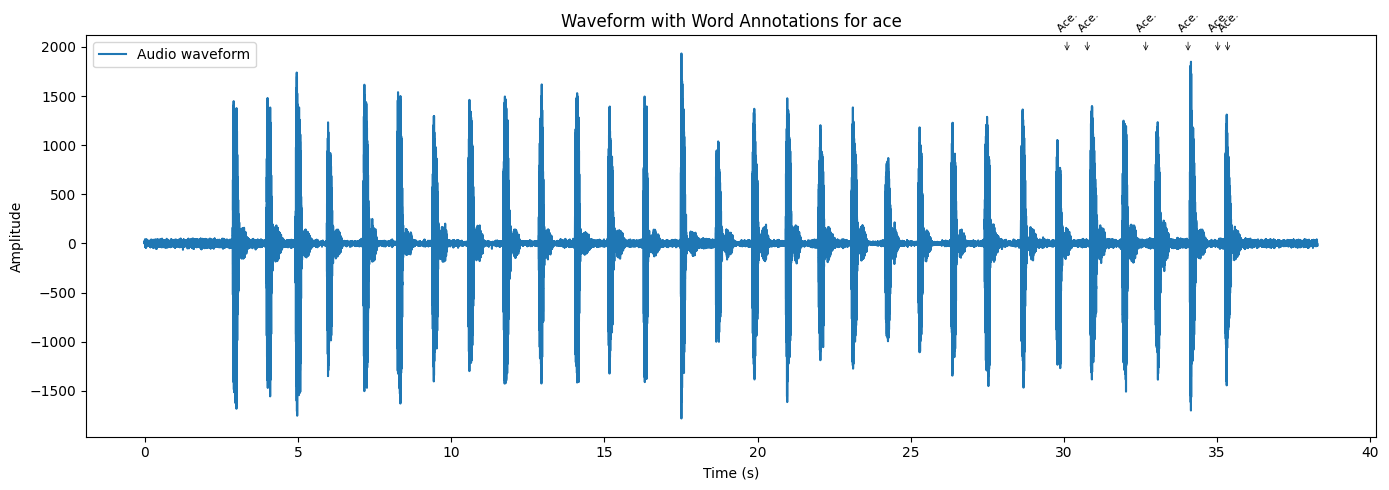


Processing dataset: aid
Word:  8 | Start: 1.60 s | End: 2.98 s
Word: -8 | Start: 2.98 s | End: 4.24 s
Word: -8 | Start: 4.24 s | End: 5.48 s
Word: -8 | Start: 5.48 s | End: 6.76 s
Word: -8 | Start: 6.76 s | End: 7.98 s
Word: -8 | Start: 7.98 s | End: 9.26 s
Word: -8 | Start: 9.26 s | End: 10.04 s
Word: -8 | Start: 10.04 s | End: 10.82 s
Word: -8 | Start: 10.82 s | End: 11.78 s
Word: -8 | Start: 11.78 s | End: 12.38 s
Word: -8 | Start: 12.38 s | End: 13.12 s
Word: -8 | Start: 13.12 s | End: 13.80 s
Word: -8 | Start: 13.80 s | End: 14.88 s
Word: -8 | Start: 14.88 s | End: 16.04 s
Word: -8 | Start: 16.04 s | End: 17.28 s
Word: -8 | Start: 17.28 s | End: 20.10 s
Word: -8 | Start: 20.10 s | End: 21.28 s
Word: -8 | Start: 21.28 s | End: 21.42 s
Word: -8 | Start: 21.42 s | End: 22.12 s
Word: -8 | Start: 22.12 s | End: 23.18 s
Word: -8 | Start: 23.18 s | End: 23.34 s
Word: -8 | Start: 23.34 s | End: 23.34 s
Word: -8 | Start: 23.34 s | End: 24.36 s
Word: -8 | Start: 24.36 s | End: 24.62 s
Word

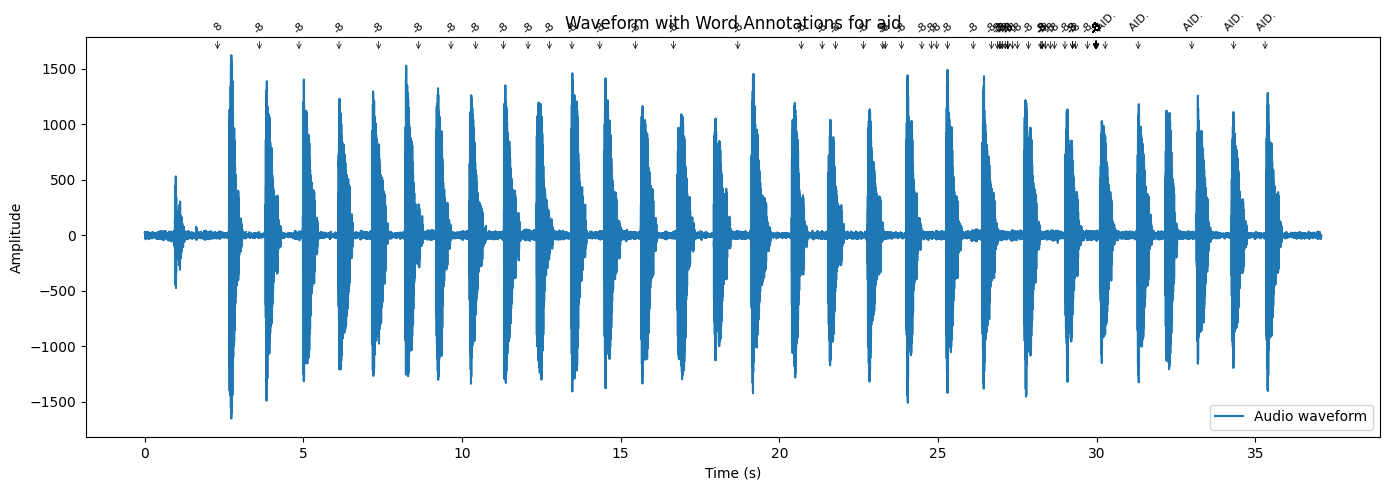


Processing dataset: come
Word:  Come. | Start: 30.00 s | End: 30.42 s
Word:  Come. | Start: 30.76 s | End: 31.50 s
Word:  Come. | Start: 32.46 s | End: 32.82 s
Word:  Come. | Start: 34.26 s | End: 34.74 s
Word:  Come. | Start: 34.74 s | End: 35.34 s
Word:  Come. | Start: 35.76 s | End: 36.58 s
Word:  Come. | Start: 37.20 s | End: 37.58 s
Word:  Come. | Start: 38.42 s | End: 38.42 s
Word:  Come. | Start: 38.46 s | End: 38.62 s
Word:  Come. | Start: 38.62 s | End: 38.78 s
Word:  Come. | Start: 39.06 s | End: 39.06 s


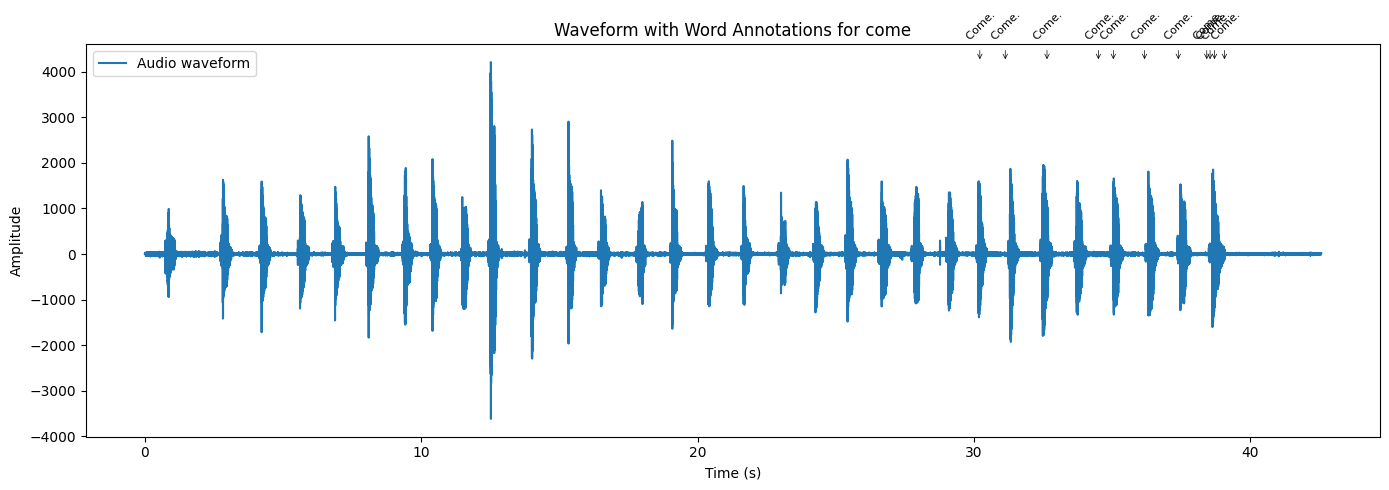


Processing dataset: day
Word:  That's | Start: 0.00 s | End: 0.14 s
Word:  gross. | Start: 0.14 s | End: 0.28 s
Word:  Day, | Start: 30.00 s | End: 30.12 s
Word:  day, | Start: 30.54 s | End: 31.52 s
Word:  day, | Start: 32.40 s | End: 33.14 s
Word:  day, | Start: 33.14 s | End: 34.40 s
Word:  day, | Start: 34.40 s | End: 35.36 s
Word:  day, | Start: 35.56 s | End: 36.40 s
Word:  day, | Start: 36.66 s | End: 37.28 s
Word:  day, | Start: 37.28 s | End: 37.54 s
Word:  day, | Start: 37.72 s | End: 38.38 s
Word:  day, | Start: 38.68 s | End: 39.50 s
Word:  day, | Start: 39.70 s | End: 39.80 s
Word:  day, | Start: 39.80 s | End: 40.68 s
Word:  day, | Start: 40.98 s | End: 40.98 s
Word:  day, | Start: 40.98 s | End: 41.00 s
Word:  day, | Start: 41.00 s | End: 41.80 s
Word:  day, | Start: 41.80 s | End: 41.84 s
Word:  day. | Start: 41.90 s | End: 41.90 s


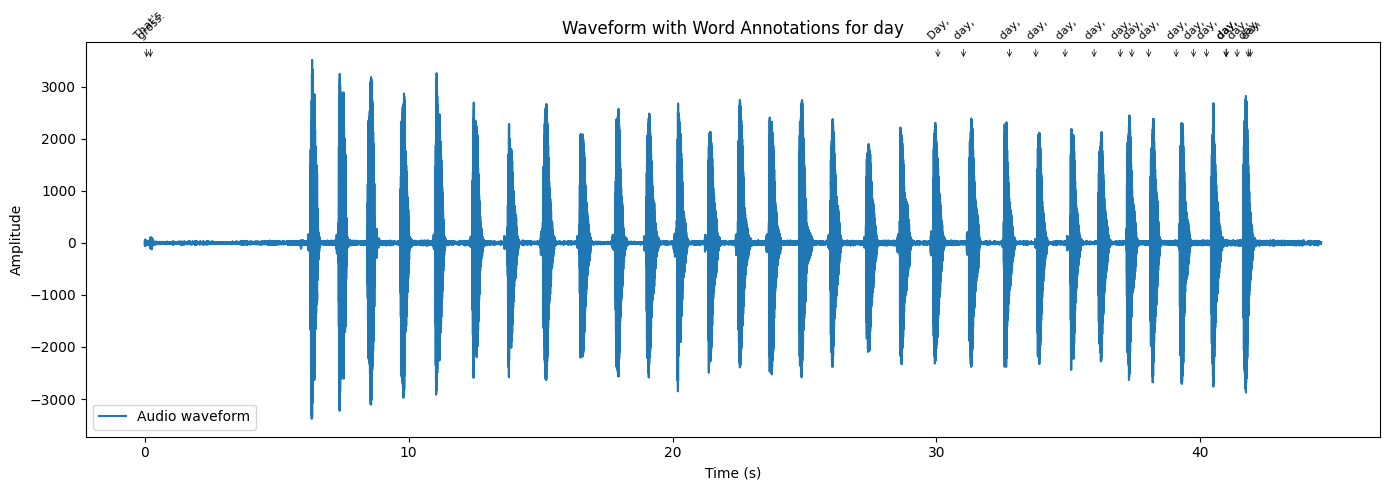


Processing dataset: dime
Word:  Dime, | Start: 3.76 s | End: 4.40 s
Word:  dime, | Start: 4.40 s | End: 5.04 s
Word:  dime, | Start: 5.64 s | End: 6.52 s
Word:  dime, | Start: 7.32 s | End: 8.32 s
Word:  dime, | Start: 8.32 s | End: 9.04 s
Word:  dime, | Start: 9.04 s | End: 9.82 s
Word:  dime, | Start: 10.00 s | End: 10.88 s
Word:  dime, | Start: 11.00 s | End: 12.02 s
Word:  dime, | Start: 12.08 s | End: 13.02 s
Word:  dime, | Start: 13.22 s | End: 13.70 s
Word:  dime, | Start: 13.70 s | End: 14.54 s
Word:  dime, | Start: 14.58 s | End: 15.62 s
Word:  dime, | Start: 15.90 s | End: 16.86 s
Word:  dime, | Start: 17.22 s | End: 18.10 s
Word:  dime, | Start: 18.48 s | End: 19.34 s
Word:  dime, | Start: 19.62 s | End: 20.48 s
Word:  dime, | Start: 20.68 s | End: 21.64 s
Word:  dime, | Start: 21.78 s | End: 22.56 s
Word:  dime, | Start: 22.96 s | End: 23.10 s
Word:  dime, | Start: 23.10 s | End: 23.62 s
Word:  dime, | Start: 23.94 s | End: 23.94 s
Word:  dime, | Start: 24.10 s | End: 24.3

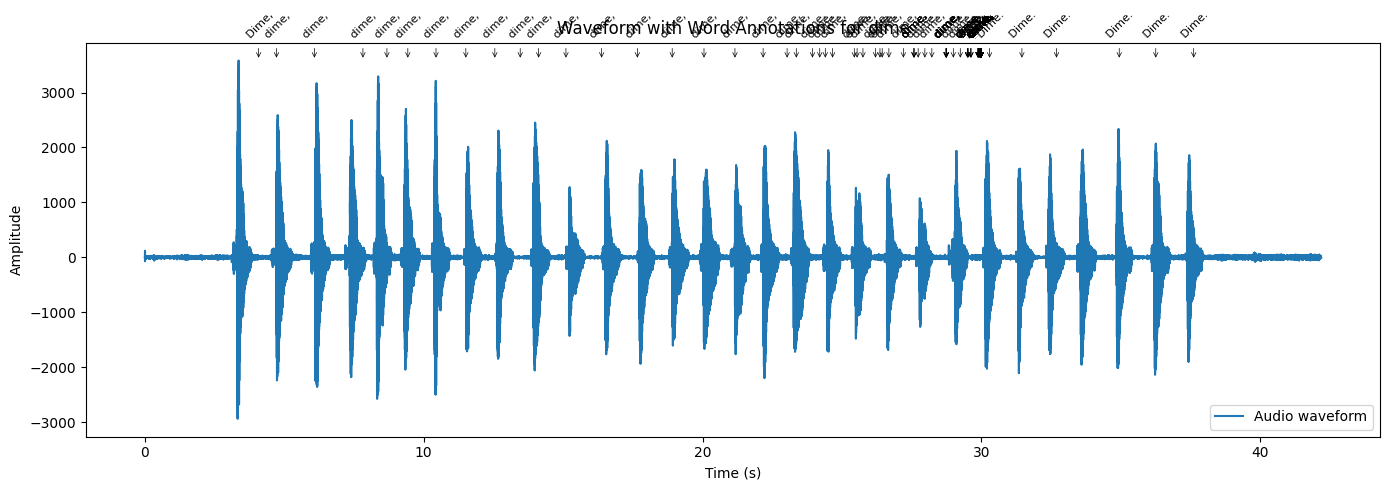


Processing dataset: doom
Word:  Doom. | Start: 30.00 s | End: 30.60 s
Word:  Doom. | Start: 30.92 s | End: 31.76 s
Word:  Doom. | Start: 32.56 s | End: 33.18 s
Word:  Doom. | Start: 33.80 s | End: 34.38 s
Word:  Doom. | Start: 34.86 s | End: 35.38 s
Word:  Doom. | Start: 36.02 s | End: 36.04 s
Word:  Doom. | Start: 36.04 s | End: 36.50 s
Word:  Doom. | Start: 37.20 s | End: 37.78 s
Word:  Doom. | Start: 38.40 s | End: 38.82 s
Word:  Doom. | Start: 39.68 s | End: 39.68 s
Word:  Doom. | Start: 39.78 s | End: 39.94 s


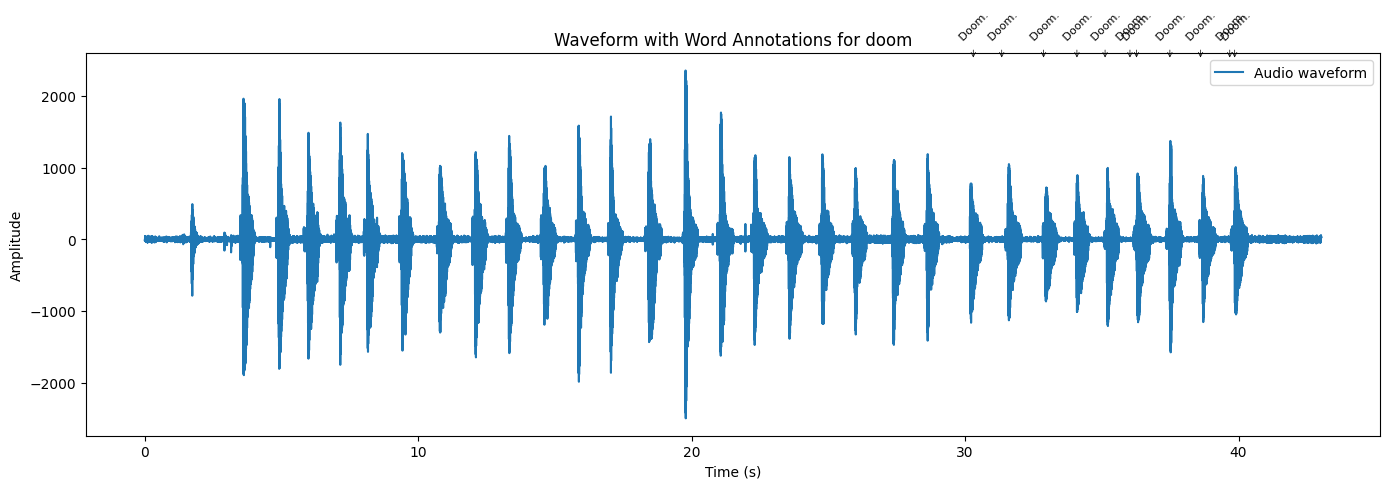


Processing dataset: dude
Word:  Dude, | Start: 30.00 s | End: 30.90 s
Word:  dude, | Start: 31.52 s | End: 32.34 s
Word:  dude, | Start: 32.88 s | End: 33.60 s
Word:  dude, | Start: 33.78 s | End: 35.18 s
Word:  dude, | Start: 35.18 s | End: 36.16 s
Word:  dude, | Start: 36.16 s | End: 36.68 s
Word:  dude, | Start: 36.70 s | End: 37.36 s
Word:  dude, | Start: 37.36 s | End: 38.12 s
Word:  dude, | Start: 38.12 s | End: 38.58 s
Word:  dude, | Start: 38.58 s | End: 38.90 s
Word:  dude, | Start: 38.90 s | End: 39.62 s
Word:  dude, | Start: 39.76 s | End: 39.76 s
Word:  dude, | Start: 39.90 s | End: 39.90 s
Word:  dude, | Start: 40.38 s | End: 40.92 s
Word:  dude, | Start: 40.92 s | End: 41.96 s
Word:  dude, | Start: 43.24 s | End: 43.24 s
Word:  dude, | Start: 43.24 s | End: 43.24 s
Word:  dude, | Start: 43.24 s | End: 43.24 s
Word:  dude, | Start: 43.24 s | End: 43.24 s
Word:  dude, | Start: 43.24 s | End: 43.24 s
Word:  dude, | Start: 43.24 s | End: 43.24 s
Word:  dude, | Start: 43.24 s

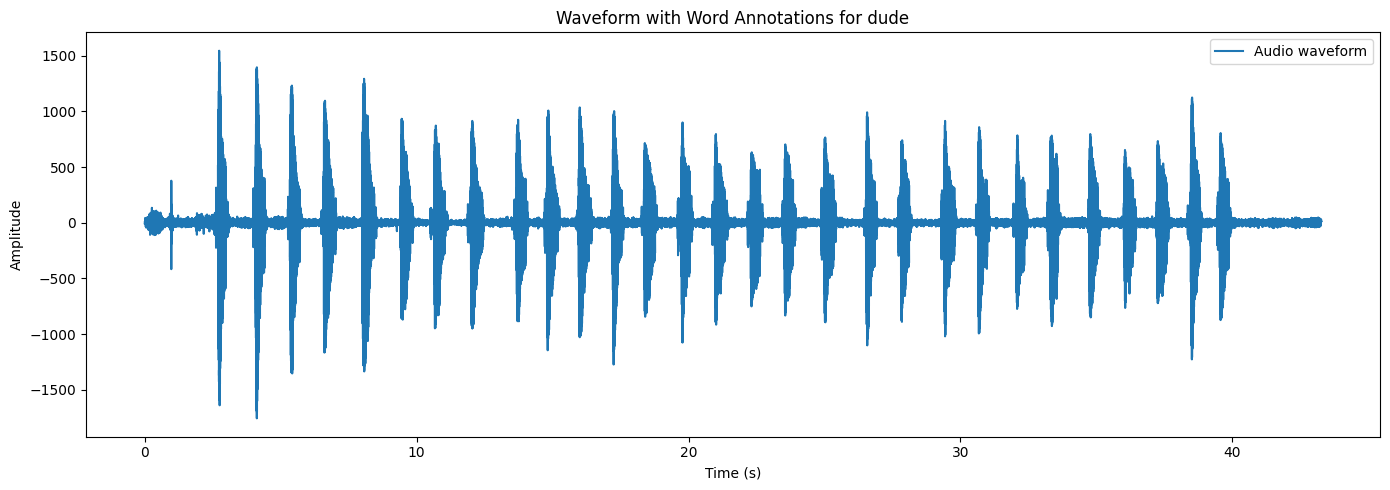


Processing dataset: key
Word:  Key, | Start: 30.00 s | End: 31.06 s
Word:  key, | Start: 31.50 s | End: 32.38 s
Word:  key, | Start: 33.02 s | End: 33.60 s
Word:  key, | Start: 34.02 s | End: 34.86 s
Word:  key, | Start: 35.22 s | End: 35.98 s
Word:  key, | Start: 36.30 s | End: 37.12 s
Word:  key, | Start: 37.46 s | End: 37.48 s
Word:  key. | Start: 37.48 s | End: 38.20 s


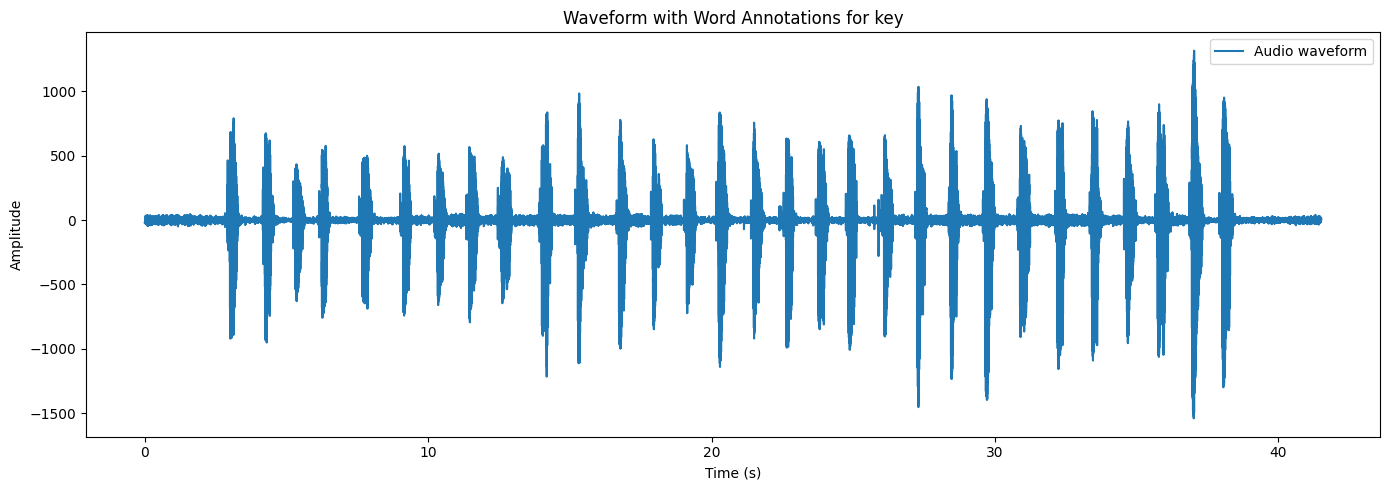


Processing dataset: make
Word:  Make, | Start: 3.14 s | End: 3.82 s
Word:  make, | Start: 3.82 s | End: 4.50 s
Word:  make, | Start: 4.96 s | End: 6.02 s
Word:  make, | Start: 6.26 s | End: 8.14 s
Word:  make, | Start: 8.48 s | End: 9.42 s
Word:  make, | Start: 9.42 s | End: 10.62 s
Word:  make, | Start: 10.90 s | End: 11.34 s
Word:  make, | Start: 11.34 s | End: 11.98 s
Word:  make, | Start: 12.32 s | End: 13.02 s
Word:  make, | Start: 13.02 s | End: 13.62 s
Word:  make, | Start: 13.62 s | End: 14.54 s
Word:  make, | Start: 14.68 s | End: 16.70 s
Word:  make, | Start: 17.08 s | End: 21.12 s
Word:  make, | Start: 21.64 s | End: 21.66 s
Word:  make, | Start: 21.66 s | End: 23.16 s
Word:  make, | Start: 23.16 s | End: 23.16 s
Word:  make, | Start: 23.52 s | End: 23.52 s
Word:  make, | Start: 23.52 s | End: 24.00 s
Word:  make, | Start: 24.00 s | End: 24.84 s
Word:  make, | Start: 24.84 s | End: 24.88 s
Word:  make, | Start: 25.10 s | End: 25.10 s
Word:  make, | Start: 25.16 s | End: 25.

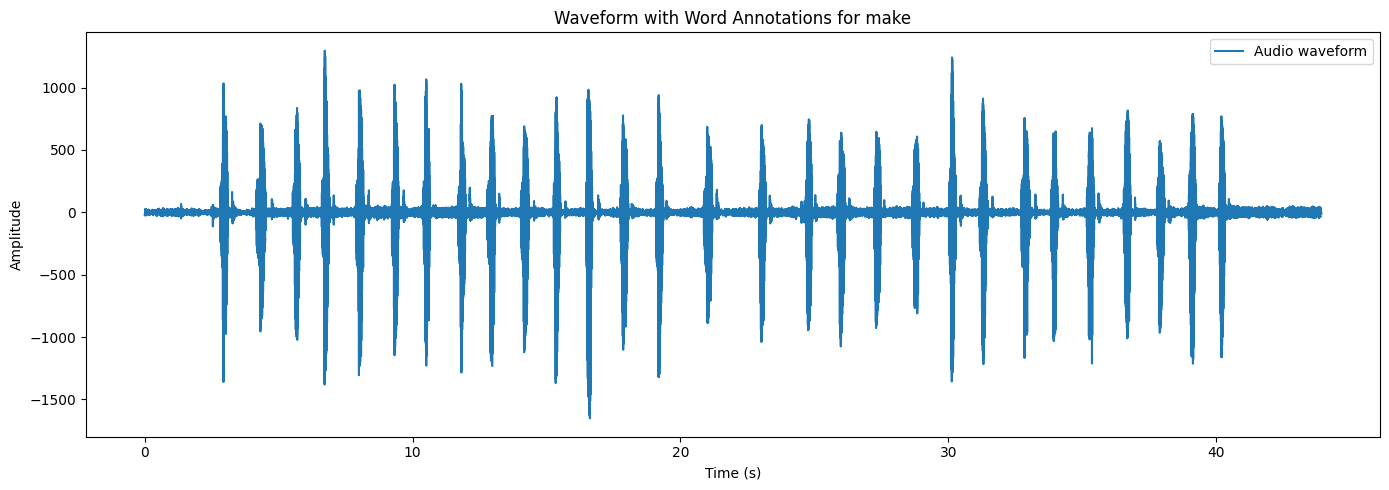


Processing dataset: may
Word:  May, | Start: 2.96 s | End: 3.84 s
Word:  may, | Start: 3.84 s | End: 4.72 s
Word:  may, | Start: 5.52 s | End: 6.00 s
Word:  may, | Start: 7.46 s | End: 8.16 s
Word:  may, | Start: 8.74 s | End: 9.46 s
Word:  may, | Start: 9.94 s | End: 10.76 s
Word:  may, | Start: 11.14 s | End: 11.98 s
Word:  may, | Start: 12.32 s | End: 12.58 s
Word:  may, | Start: 12.58 s | End: 13.12 s
Word:  may, | Start: 13.54 s | End: 14.22 s
Word:  may, | Start: 14.60 s | End: 15.42 s
Word:  may, | Start: 15.86 s | End: 16.50 s
Word:  may, | Start: 16.96 s | End: 17.74 s
Word:  may, | Start: 18.18 s | End: 18.96 s
Word:  may, | Start: 19.44 s | End: 20.12 s
Word:  may, | Start: 20.68 s | End: 21.26 s
Word:  may, | Start: 21.52 s | End: 21.52 s
Word:  may, | Start: 21.84 s | End: 21.84 s
Word:  may, | Start: 21.84 s | End: 22.52 s
Word:  may, | Start: 23.10 s | End: 23.10 s
Word:  may, | Start: 23.10 s | End: 23.48 s
Word:  may, | Start: 23.48 s | End: 23.68 s
Word:  may, | Star

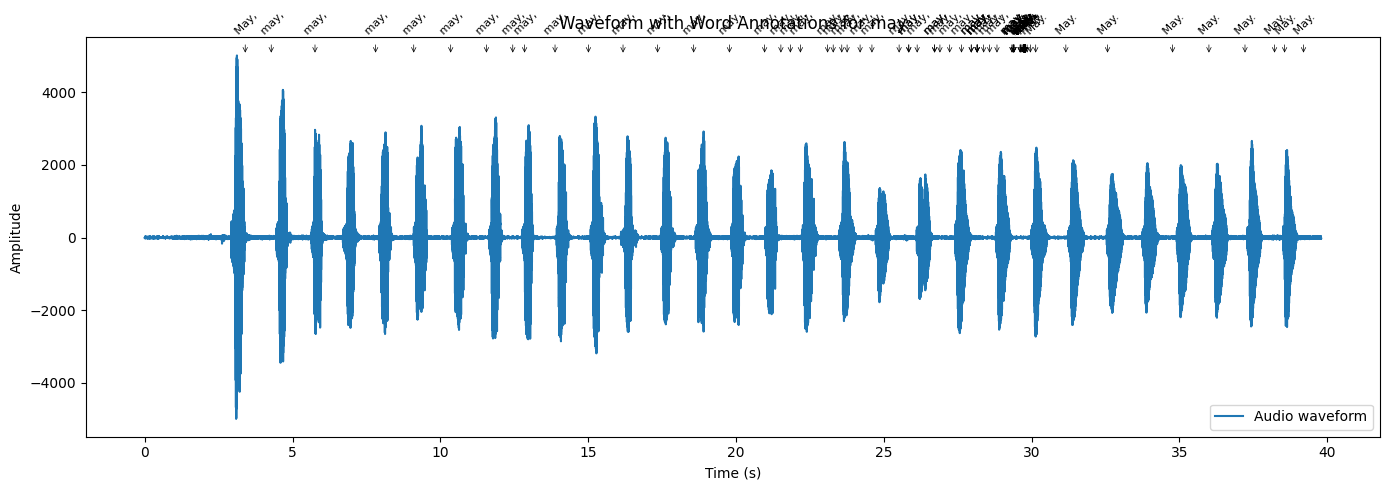


Processing dataset: moo
Word:  Mil | Start: 2.26 s | End: 3.66 s
Word:  mil | Start: 3.66 s | End: 5.02 s
Word:  mil | Start: 5.02 s | End: 6.18 s
Word:  mil | Start: 6.18 s | End: 8.20 s
Word:  mil | Start: 8.20 s | End: 10.24 s
Word:  mil | Start: 10.24 s | End: 11.14 s
Word:  mil | Start: 11.14 s | End: 11.86 s
Word:  mil | Start: 11.86 s | End: 13.00 s
Word:  mil | Start: 13.00 s | End: 14.34 s
Word:  mil | Start: 14.34 s | End: 15.60 s
Word:  mil | Start: 15.60 s | End: 17.02 s
Word:  mil | Start: 17.02 s | End: 19.34 s
Word:  mil | Start: 19.34 s | End: 20.52 s
Word:  mil | Start: 20.52 s | End: 21.58 s
Word:  mil | Start: 21.58 s | End: 21.78 s
Word:  mil | Start: 21.78 s | End: 21.78 s
Word:  mil | Start: 21.78 s | End: 22.80 s
Word:  mil | Start: 22.80 s | End: 22.80 s
Word:  mil | Start: 22.80 s | End: 22.82 s
Word:  mil | Start: 22.82 s | End: 23.06 s
Word:  mil | Start: 23.06 s | End: 23.16 s
Word:  mil | Start: 23.16 s | End: 23.92 s
Word:  mil | Start: 23.92 s | End: 24.

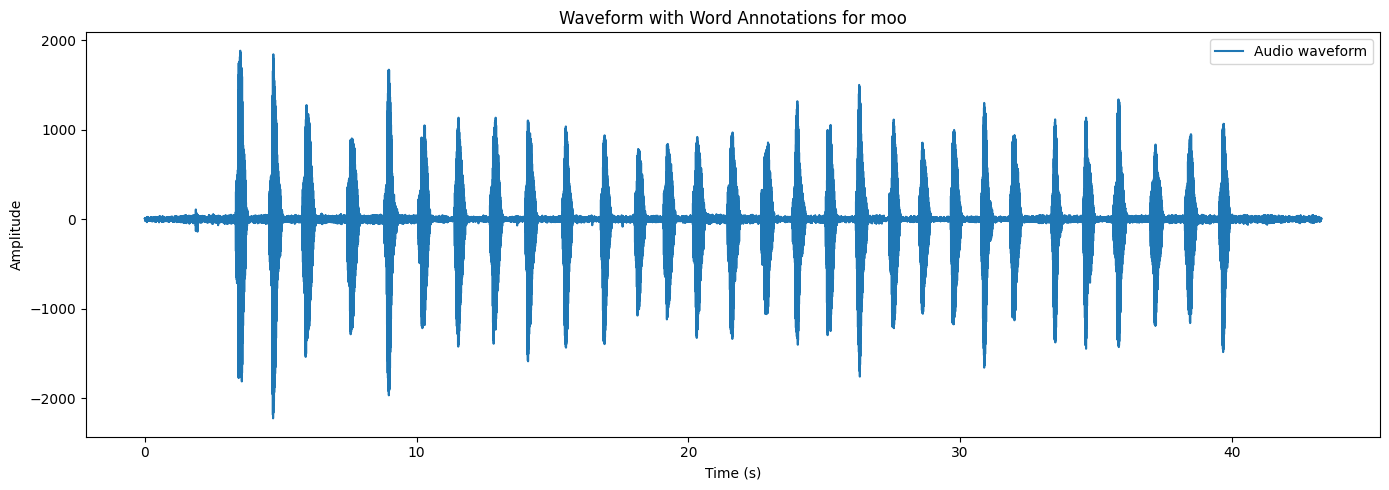


Processing dataset: moose
Word:  Moose. | Start: 2.92 s | End: 3.82 s
Word:  Moose. | Start: 4.18 s | End: 5.08 s
Word:  Moose. | Start: 5.82 s | End: 6.28 s
Word:  Moose. | Start: 7.92 s | End: 8.40 s
Word:  Moose. | Start: 10.22 s | End: 10.88 s
Word:  Moose. | Start: 11.60 s | End: 12.50 s
Word:  Moose. | Start: 13.08 s | End: 13.74 s
Word:  Moose. | Start: 15.24 s | End: 15.94 s
Word:  Moose. | Start: 16.78 s | End: 17.40 s
Word:  Moose. | Start: 19.20 s | End: 19.92 s
Word:  Moose. | Start: 20.38 s | End: 21.28 s
Word:  Moose. | Start: 21.66 s | End: 22.48 s
Word:  Moose. | Start: 22.92 s | End: 22.92 s
Word:  Moose. | Start: 23.00 s | End: 23.84 s
Word:  Moose. | Start: 24.18 s | End: 24.66 s
Word:  Moose. | Start: 24.66 s | End: 25.26 s
Word:  Moose. | Start: 26.04 s | End: 26.26 s
Word:  Moose. | Start: 26.26 s | End: 26.50 s
Word:  Moose. | Start: 26.64 s | End: 26.64 s
Word:  Moose. | Start: 26.94 s | End: 27.84 s
Word:  Moose. | Start: 28.42 s | End: 28.42 s
Word:  Moose. |

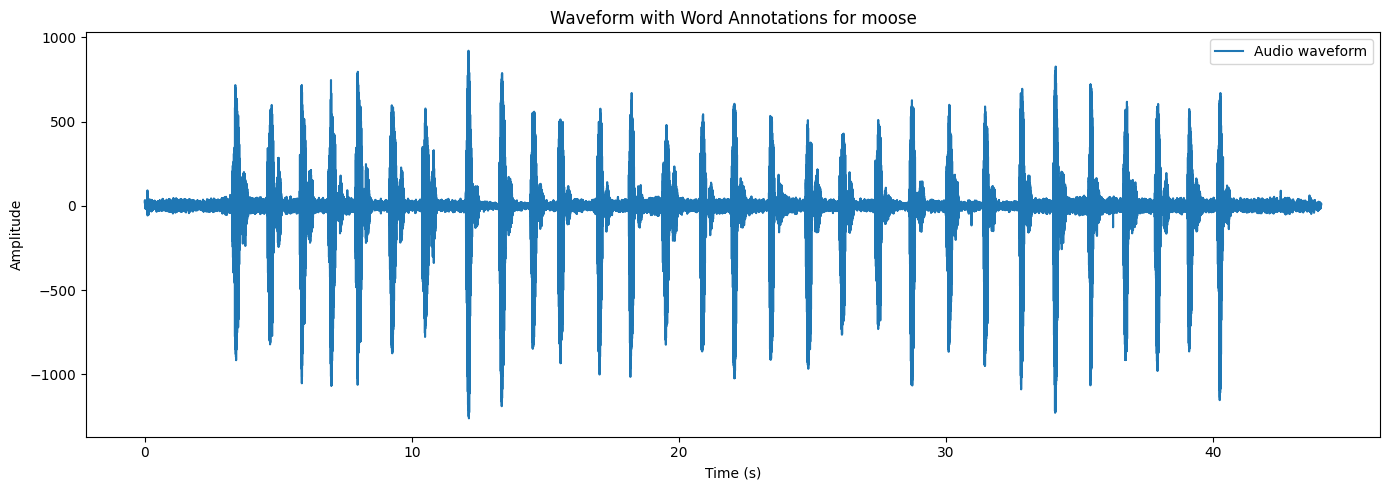


Processing dataset: my
Word:  My, | Start: 2.88 s | End: 3.68 s
Word:  my, | Start: 3.68 s | End: 4.48 s
Word:  my, | Start: 4.96 s | End: 6.12 s
Word:  my, | Start: 6.52 s | End: 7.56 s
Word:  my, | Start: 8.12 s | End: 8.82 s
Word:  my, | Start: 9.36 s | End: 10.06 s
Word:  my, | Start: 10.40 s | End: 11.26 s
Word:  my, | Start: 11.64 s | End: 12.56 s
Word:  my, | Start: 12.82 s | End: 12.82 s
Word:  my, | Start: 12.98 s | End: 13.78 s
Word:  my, | Start: 14.08 s | End: 14.98 s
Word:  my, | Start: 15.44 s | End: 17.30 s
Word:  my, | Start: 17.88 s | End: 18.50 s
Word:  my, | Start: 18.98 s | End: 19.84 s
Word:  my, | Start: 20.18 s | End: 20.94 s
Word:  my, | Start: 21.44 s | End: 21.94 s
Word:  my, | Start: 21.94 s | End: 22.12 s
Word:  my, | Start: 22.20 s | End: 22.20 s
Word:  my, | Start: 22.20 s | End: 22.20 s
Word:  my, | Start: 22.86 s | End: 22.86 s
Word:  my, | Start: 22.86 s | End: 23.44 s
Word:  my, | Start: 23.66 s | End: 23.66 s
Word:  my, | Start: 23.88 s | End: 23.88 

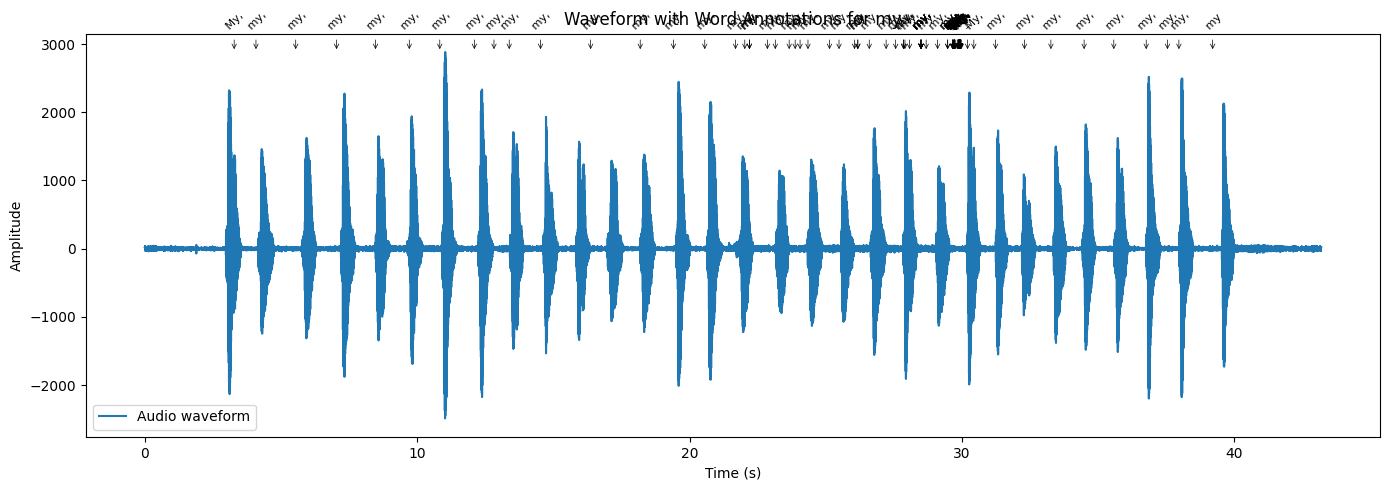


Processing dataset: ray
Word:  Ray, | Start: 30.00 s | End: 30.64 s
Word:  Ray, | Start: 31.00 s | End: 31.64 s
Word:  Ray. | Start: 32.02 s | End: 32.88 s


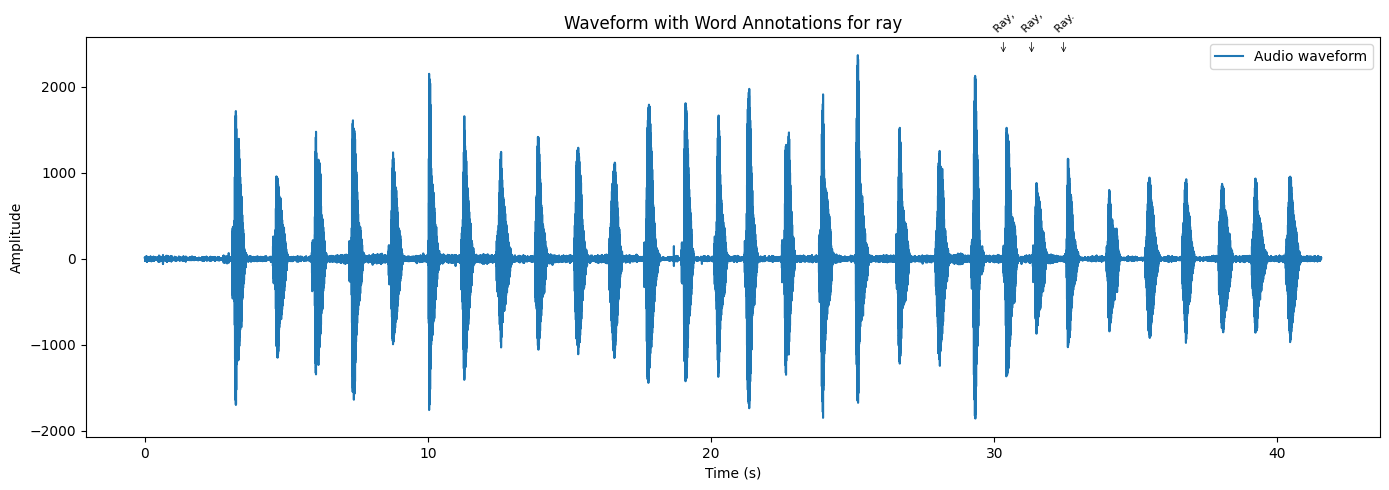


Processing dataset: rock
Word:  Rock, | Start: 1.72 s | End: 3.00 s
Word:  rock, | Start: 3.38 s | End: 4.08 s
Word:  rock, | Start: 4.62 s | End: 5.56 s
Word:  rock, | Start: 5.56 s | End: 7.32 s
Word:  rock, | Start: 7.34 s | End: 8.56 s
Word:  rock, | Start: 8.56 s | End: 9.66 s
Word:  rock, | Start: 9.66 s | End: 10.62 s
Word:  rock, | Start: 10.62 s | End: 12.00 s
Word:  rock, | Start: 12.00 s | End: 13.20 s
Word:  rock, | Start: 13.20 s | End: 13.78 s
Word:  rock, | Start: 13.78 s | End: 15.84 s
Word:  rock, | Start: 15.84 s | End: 19.78 s
Word:  rock, | Start: 19.78 s | End: 20.52 s
Word:  rock, | Start: 20.52 s | End: 20.82 s
Word:  rock, | Start: 20.82 s | End: 21.74 s
Word:  rock, | Start: 21.74 s | End: 22.50 s
Word:  rock, | Start: 22.50 s | End: 22.50 s
Word:  rock, | Start: 22.50 s | End: 23.08 s
Word:  rock, | Start: 23.08 s | End: 23.40 s
Word:  rock, | Start: 23.40 s | End: 23.86 s
Word:  rock, | Start: 23.86 s | End: 24.32 s
Word:  rock, | Start: 24.32 s | End: 24.32

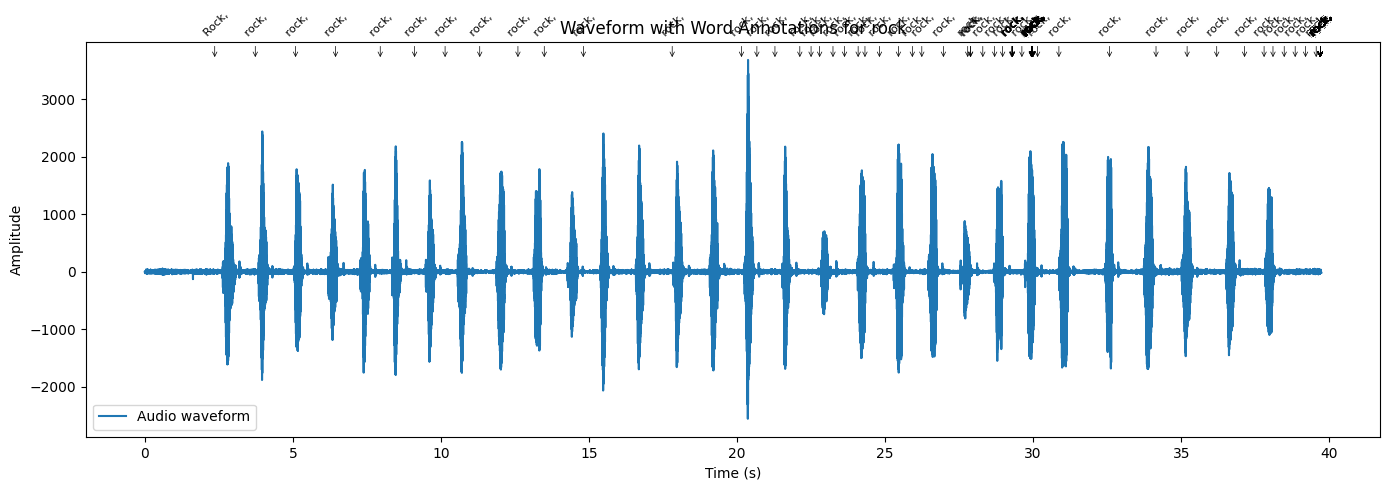


Processing dataset: rum
Word:  Rum, | Start: 30.00 s | End: 30.50 s
Word:  Rum, | Start: 30.94 s | End: 31.44 s
Word:  Rum, | Start: 32.40 s | End: 32.92 s
Word:  Rum, | Start: 32.92 s | End: 33.98 s
Word:  Rum, | Start: 34.06 s | End: 35.24 s
Word:  Rum, | Start: 35.24 s | End: 35.88 s
Word:  Rum, | Start: 35.88 s | End: 36.52 s
Word:  Rum, | Start: 37.22 s | End: 37.22 s
Word:  Rum, | Start: 37.22 s | End: 37.44 s
Word:  Rum, | Start: 37.44 s | End: 38.00 s
Word:  Rum, | Start: 38.00 s | End: 38.62 s
Word:  Rum, | Start: 38.62 s | End: 38.90 s
Word:  Rum, | Start: 38.90 s | End: 39.32 s
Word:  Rum, | Start: 39.32 s | End: 39.74 s
Word:  Rum, | Start: 39.74 s | End: 39.78 s
Word:  Rum, | Start: 39.98 s | End: 40.16 s
Word:  Rum, | Start: 40.16 s | End: 40.78 s
Word:  Rum, | Start: 40.78 s | End: 41.42 s
Word:  Rum, | Start: 41.42 s | End: 41.62 s
Word:  Rum, | Start: 41.62 s | End: 42.36 s
Word:  Rum, | Start: 42.36 s | End: 42.82 s
Word:  Rum, | Start: 43.72 s | End: 43.72 s
Word:  

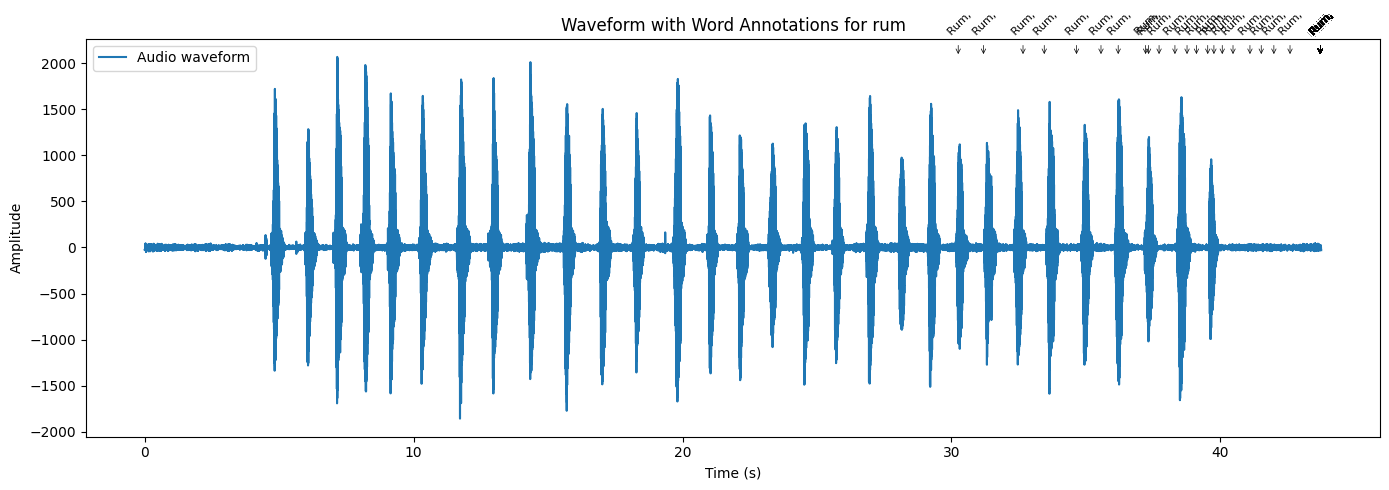


Processing dataset: same
Word:  Same. | Start: 30.00 s | End: 30.14 s
Word:  Same. | Start: 30.46 s | End: 31.16 s
Word:  Same. | Start: 32.64 s | End: 33.38 s
Word:  Same. | Start: 34.04 s | End: 34.68 s
Word:  Same. | Start: 35.36 s | End: 35.36 s
Word:  Same. | Start: 36.70 s | End: 37.10 s
Word:  Same. | Start: 37.84 s | End: 37.84 s
Word:  Same. | Start: 37.96 s | End: 38.46 s
Word:  Same. | Start: 39.00 s | End: 39.42 s
Word:  Same. | Start: 39.42 s | End: 39.50 s


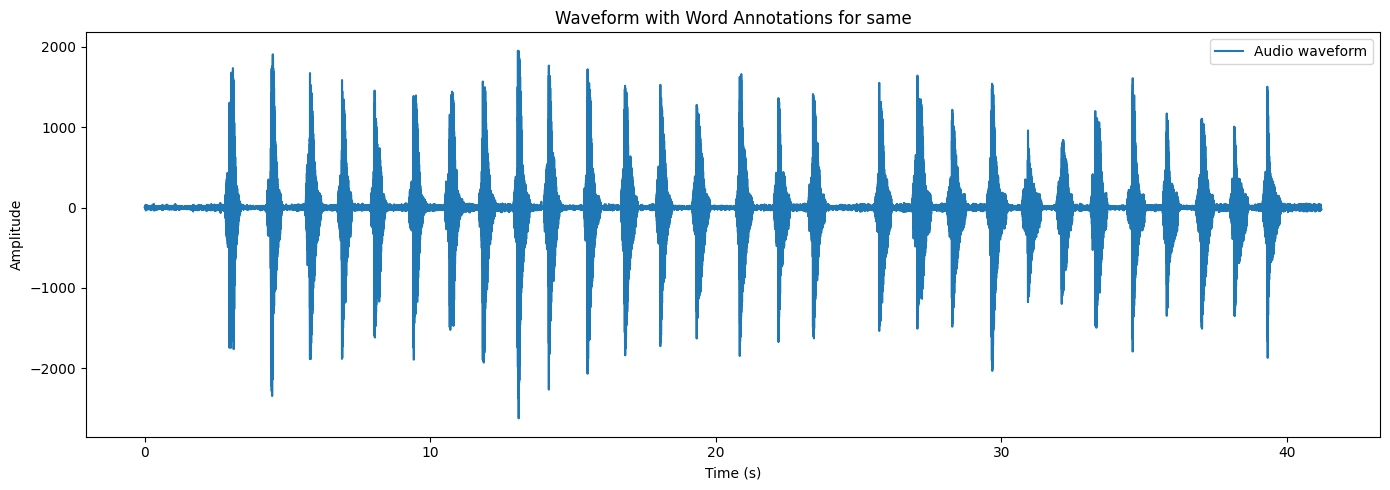


Processing dataset: seam
Word:  C | Start: 30.00 s | End: 30.00 s
Word: - | Start: 30.00 s | End: 30.26 s
Word:  c | Start: 30.26 s | End: 31.04 s
Word: - | Start: 31.04 s | End: 31.38 s
Word:  c | Start: 31.38 s | End: 32.56 s
Word: - | Start: 32.56 s | End: 32.56 s
Word:  c, | Start: 32.56 s | End: 33.30 s
Word:  C | Start: 33.30 s | End: 33.30 s
Word: - | Start: 33.30 s | End: 33.58 s
Word:  c, | Start: 33.58 s | End: 34.44 s
Word:  hee | Start: 39.42 s | End: 40.82 s


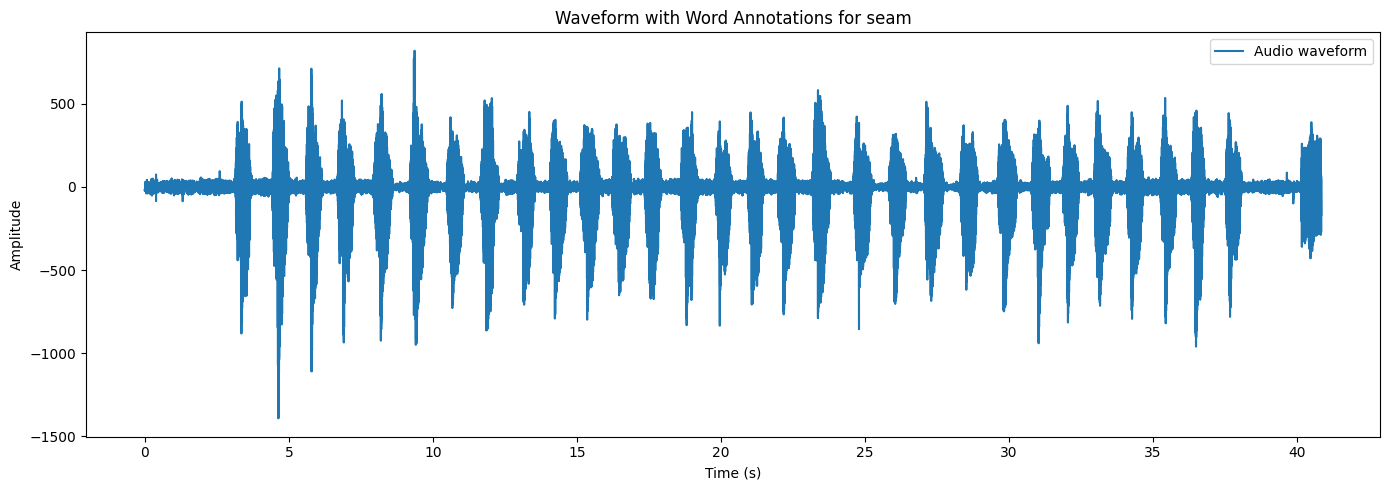


Processing dataset: seed
Word:  Seed. | Start: 3.86 s | End: 4.56 s
Word:  Seed. | Start: 4.56 s | End: 5.26 s
Word:  Seed. | Start: 5.80 s | End: 6.38 s
Word:  Seed. | Start: 8.00 s | End: 8.70 s
Word:  Seed. | Start: 9.36 s | End: 10.06 s
Word:  Seed. | Start: 11.04 s | End: 11.74 s
Word:  Seed. | Start: 12.20 s | End: 12.22 s
Word:  Seed. | Start: 12.32 s | End: 13.02 s
Word:  Seed. | Start: 13.64 s | End: 14.34 s
Word:  Seed. | Start: 14.94 s | End: 15.58 s
Word:  Seed. | Start: 17.24 s | End: 17.94 s
Word:  Seed. | Start: 19.50 s | End: 20.20 s
Word:  Seed. | Start: 20.62 s | End: 21.32 s
Word:  Seed. | Start: 21.74 s | End: 21.94 s
Word:  Seed. | Start: 21.94 s | End: 22.32 s
Word:  Seed. | Start: 22.50 s | End: 22.82 s
Word:  Seed. | Start: 22.84 s | End: 23.54 s
Word:  Seed. | Start: 24.06 s | End: 24.06 s
Word:  Seed. | Start: 24.08 s | End: 24.10 s
Word:  Seed. | Start: 24.10 s | End: 24.78 s
Word:  Seed. | Start: 25.06 s | End: 25.18 s
Word:  Seed. | Start: 25.18 s | End: 2

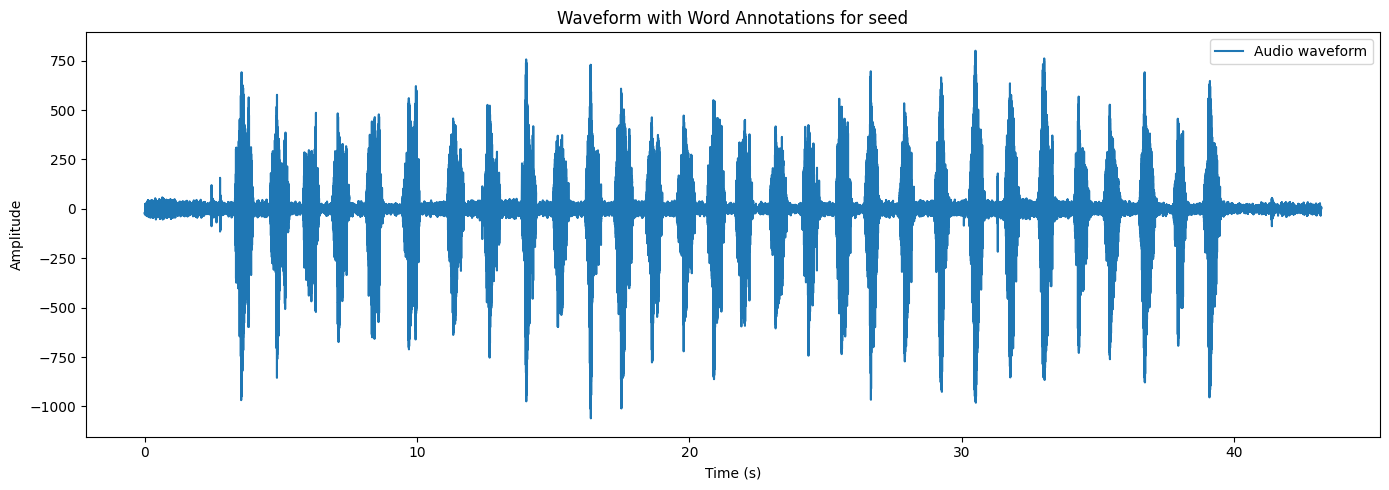


Processing dataset: seek
Word:  Seek | Start: 30.00 s | End: 30.28 s
Word: !ast | Start: 30.28 s | End: 32.44 s
Word: !Seek | Start: 32.44 s | End: 32.82 s
Word: !Seek | Start: 32.82 s | End: 34.20 s
Word: !Seek | Start: 34.20 s | End: 35.24 s
Word: !Seek | Start: 35.24 s | End: 37.62 s
Word: !Seek | Start: 37.62 s | End: 38.74 s
Word: !Seek | Start: 38.74 s | End: 39.50 s
Word: !Seek | Start: 39.50 s | End: 39.74 s
Word: !Seek | Start: 39.74 s | End: 39.96 s
Word: !Seek | Start: 39.96 s | End: 40.52 s
Word: !Seek | Start: 40.52 s | End: 42.04 s
Word: !Seek | Start: 42.04 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !Seek | Start: 43.84 s | End: 43.84 s
Word: !

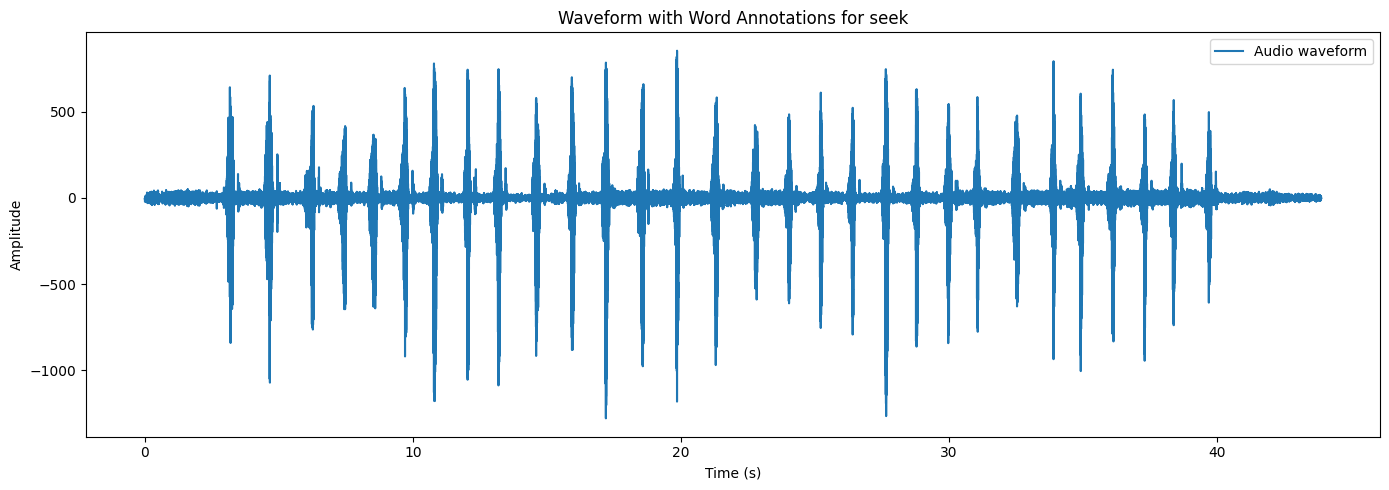


Processing dataset: shave
Word:  Save, | Start: 2.42 s | End: 3.38 s
Word:  save, | Start: 3.78 s | End: 4.60 s
Word:  save, | Start: 5.02 s | End: 5.84 s
Word:  save, | Start: 6.04 s | End: 7.94 s
Word:  save, | Start: 7.94 s | End: 9.08 s
Word:  save, | Start: 9.08 s | End: 10.78 s
Word:  save, | Start: 10.78 s | End: 12.38 s
Word:  save, | Start: 12.66 s | End: 13.96 s
Word:  save, | Start: 13.96 s | End: 14.68 s
Word:  save, | Start: 14.68 s | End: 16.32 s
Word:  save, | Start: 16.32 s | End: 18.92 s
Word:  save, | Start: 19.40 s | End: 19.88 s
Word:  save, | Start: 20.06 s | End: 21.38 s
Word:  save, | Start: 21.62 s | End: 22.34 s
Word:  save, | Start: 22.34 s | End: 22.68 s
Word:  save, | Start: 22.78 s | End: 23.16 s
Word:  save, | Start: 23.16 s | End: 23.64 s
Word:  save, | Start: 23.64 s | End: 23.90 s
Word:  save, | Start: 24.22 s | End: 24.32 s
Word:  save, | Start: 24.32 s | End: 24.98 s
Word:  save, | Start: 24.98 s | End: 25.40 s
Word:  save, | Start: 25.58 s | End: 25

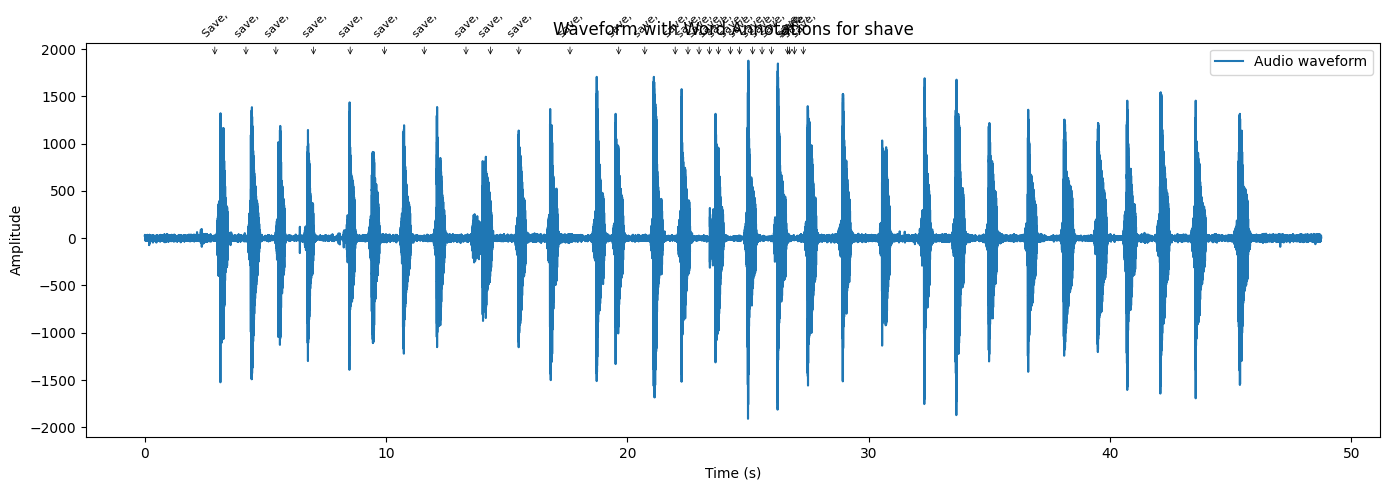


Processing dataset: she
Word: 詩 | Start: 1.80 s | End: 3.20 s
Word: 詩 | Start: 3.20 s | End: 4.46 s
Word: 詩 | Start: 4.46 s | End: 5.86 s
Word: 詩 | Start: 5.86 s | End: 6.90 s
Word: 詩 | Start: 6.90 s | End: 8.42 s
Word: 詩 | Start: 8.42 s | End: 8.84 s
Word: 詩 | Start: 8.84 s | End: 8.86 s
Word: 詩 | Start: 8.86 s | End: 11.14 s
Word: 詩 | Start: 16.04 s | End: 17.44 s
Word: 詩 | Start: 17.44 s | End: 17.56 s
Word: 詩 | Start: 17.56 s | End: 19.88 s
Word: 詩 | Start: 19.88 s | End: 21.34 s
Word: 詩 | Start: 21.34 s | End: 22.56 s
Word: 詩 | Start: 22.56 s | End: 23.10 s
Word: 詩 | Start: 23.10 s | End: 24.20 s
Word: 詩 | Start: 24.20 s | End: 25.40 s
Word: 詩 | Start: 25.40 s | End: 26.56 s


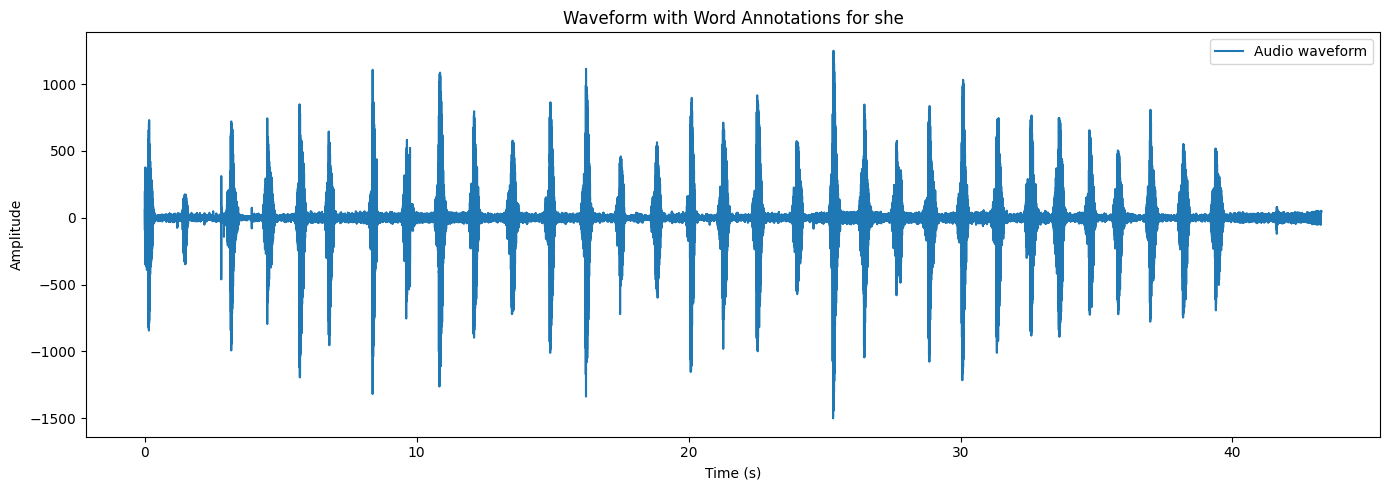


Processing dataset: shock
Word:  Shak | Start: 2.14 s | End: 3.14 s
Word: -Shak | Start: 3.14 s | End: 4.14 s
Word: -Shak | Start: 4.14 s | End: 7.26 s
Word: -Shak | Start: 7.26 s | End: 8.60 s
Word: -Shak | Start: 8.60 s | End: 9.84 s
Word: -Shak | Start: 9.84 s | End: 11.28 s
Word: -Shak | Start: 11.28 s | End: 11.72 s
Word: -Shak | Start: 11.72 s | End: 12.54 s
Word: -Shak | Start: 12.54 s | End: 14.40 s
Word: -Shak | Start: 14.40 s | End: 18.38 s
Word: -Shak | Start: 18.38 s | End: 19.74 s
Word: -Shak | Start: 19.74 s | End: 20.98 s
Word: -Shak | Start: 20.98 s | End: 21.96 s
Word: -Shak | Start: 21.96 s | End: 21.96 s
Word: -Shak | Start: 21.96 s | End: 22.76 s
Word: -Shak | Start: 22.76 s | End: 22.98 s
Word: -Shak | Start: 22.98 s | End: 23.54 s
Word: -Shak | Start: 23.54 s | End: 23.80 s
Word: -Shak | Start: 23.80 s | End: 23.92 s
Word: -Shak | Start: 23.92 s | End: 24.96 s
Word: -Shak | Start: 24.96 s | End: 25.14 s
Word: -Shak | Start: 25.14 s | End: 26.04 s
Word: -Shak | St

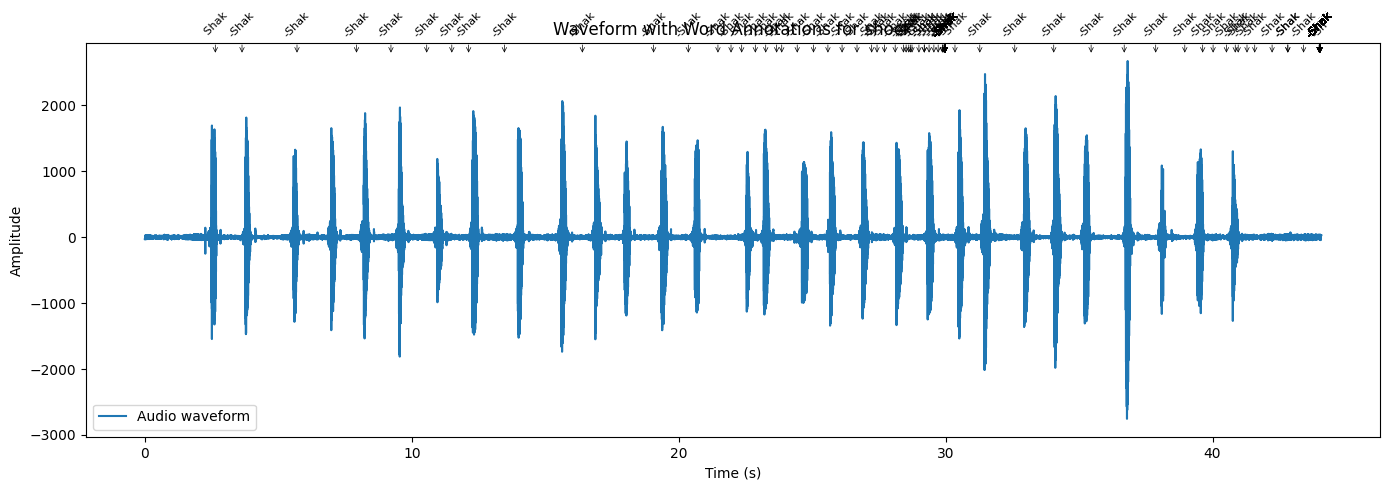


Processing dataset: shoe
Word:  Shoo | Start: 3.68 s | End: 4.52 s
Word:  shoo | Start: 4.52 s | End: 5.36 s
Word:  shoo | Start: 5.36 s | End: 8.28 s
Word:  shoo | Start: 8.28 s | End: 9.40 s
Word:  shoo | Start: 9.40 s | End: 10.62 s
Word:  shoo | Start: 10.62 s | End: 12.28 s
Word:  shoo | Start: 12.28 s | End: 12.78 s
Word:  shoo | Start: 12.78 s | End: 13.26 s
Word:  shoo | Start: 13.26 s | End: 15.00 s
Word:  shoo | Start: 15.00 s | End: 16.12 s
Word:  shoo | Start: 16.12 s | End: 22.12 s
Word:  shoo | Start: 22.12 s | End: 22.54 s
Word:  shoo | Start: 22.54 s | End: 23.66 s
Word:  shoo | Start: 23.66 s | End: 23.94 s
Word:  shoo | Start: 23.94 s | End: 24.22 s
Word:  shoo | Start: 24.22 s | End: 24.96 s
Word:  shoo | Start: 24.96 s | End: 25.38 s
Word:  shoo | Start: 25.38 s | End: 26.10 s
Word:  shoo | Start: 26.10 s | End: 26.26 s
Word:  shoo | Start: 26.26 s | End: 26.38 s
Word:  shoo | Start: 26.38 s | End: 26.38 s
Word:  shoo | Start: 26.38 s | End: 26.38 s
Word:  shoo | S

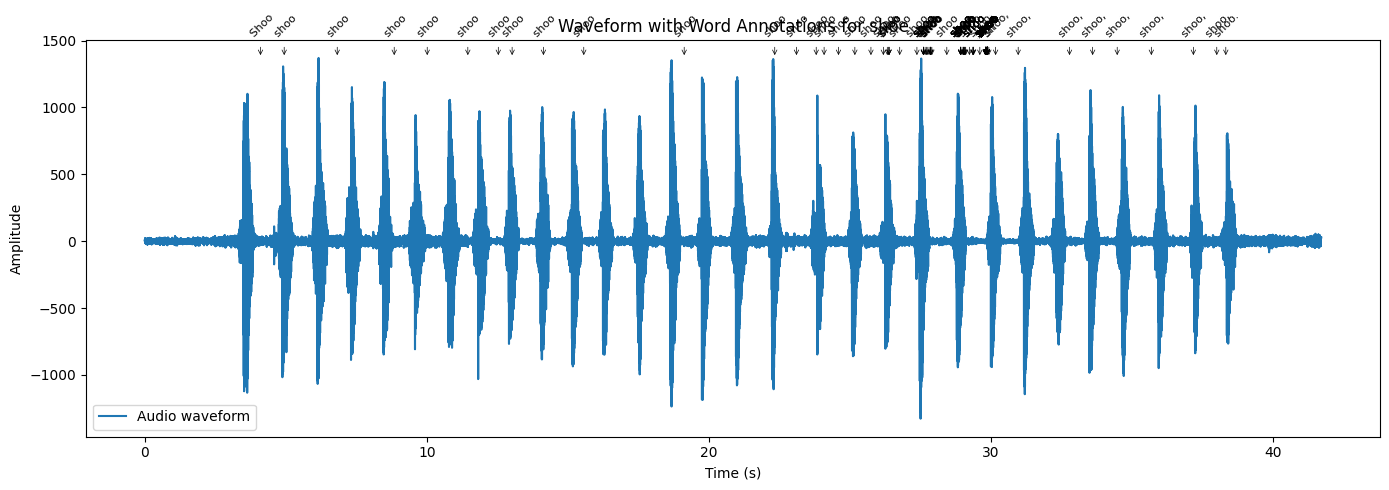


Processing dataset: shy
Word:  Shai | Start: 2.86 s | End: 3.82 s
Word:  shai | Start: 3.82 s | End: 4.78 s
Word:  shai | Start: 4.78 s | End: 6.70 s
Word:  shai | Start: 6.70 s | End: 8.68 s
Word:  shai | Start: 8.68 s | End: 9.42 s
Word:  shai | Start: 9.42 s | End: 10.90 s
Word:  shai | Start: 10.90 s | End: 11.48 s
Word:  shai | Start: 11.48 s | End: 12.70 s
Word:  shai | Start: 12.70 s | End: 14.22 s
Word:  shai | Start: 14.22 s | End: 15.24 s
Word:  shai | Start: 15.24 s | End: 21.28 s
Word:  shai | Start: 21.28 s | End: 21.76 s
Word:  shai | Start: 21.76 s | End: 23.06 s
Word:  shai | Start: 23.06 s | End: 23.06 s
Word:  shai | Start: 23.06 s | End: 23.28 s
Word:  shai | Start: 23.28 s | End: 23.92 s
Word:  shai | Start: 23.92 s | End: 24.48 s
Word:  shai | Start: 24.48 s | End: 24.60 s
Word:  shai | Start: 24.60 s | End: 25.36 s
Word:  shai | Start: 25.36 s | End: 25.36 s
Word:  shai | Start: 25.36 s | End: 25.36 s
Word:  shai | Start: 25.36 s | End: 25.48 s
Word:  shai | Star

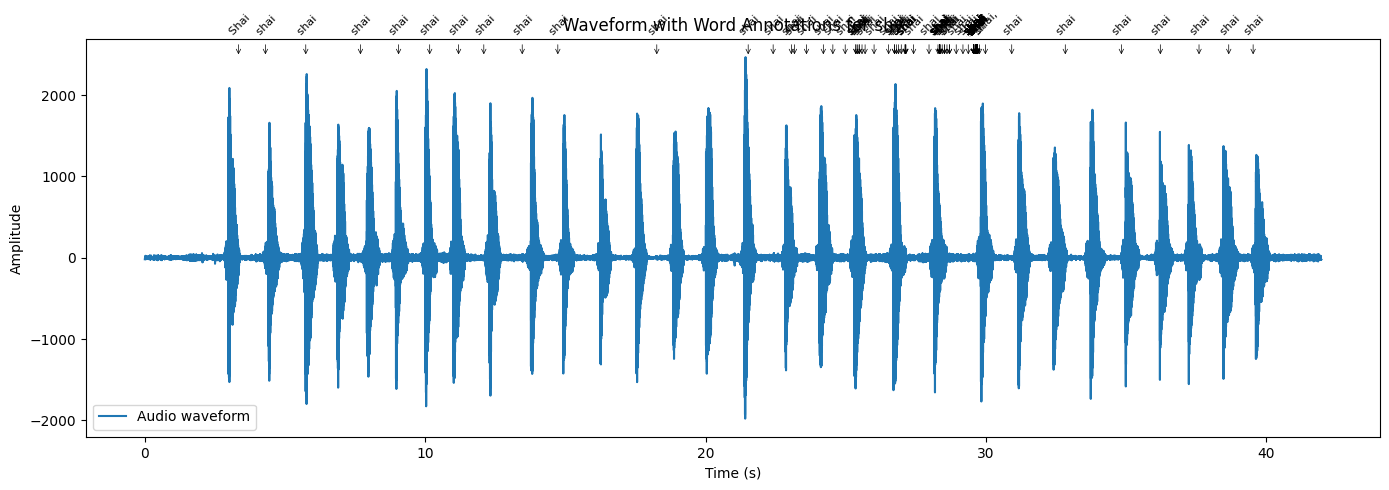


Processing dataset: side
Word:  side | Start: 2.02 s | End: 3.42 s
Word:  side | Start: 40.96 s | End: 42.36 s


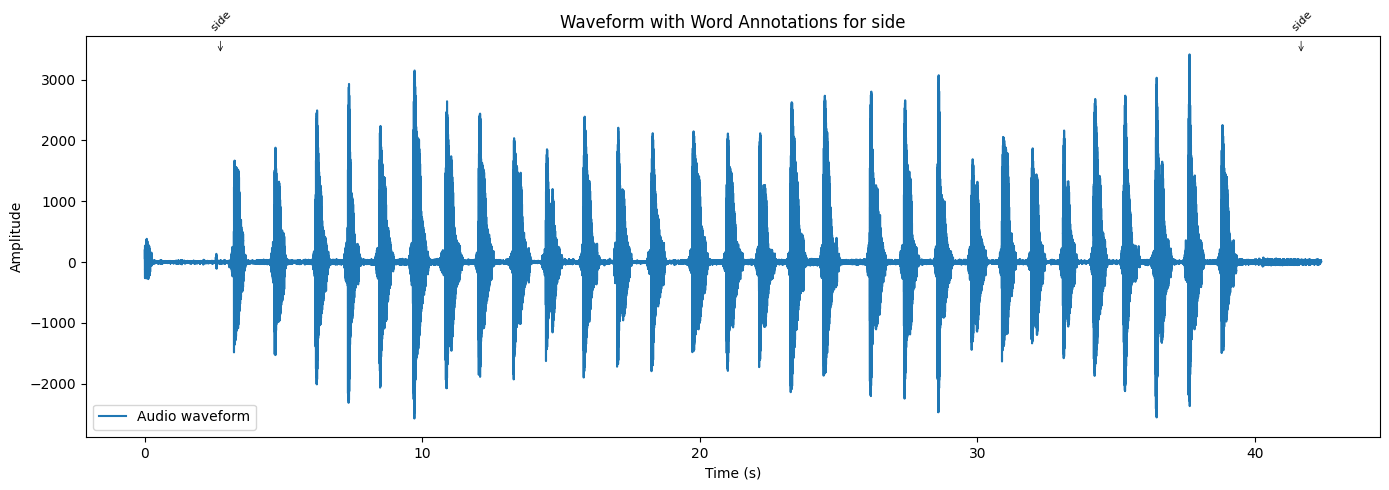


Processing dataset: sigh
Word: 塞 | Start: 0.00 s | End: 0.98 s
Word: 塞 | Start: 2.70 s | End: 4.10 s
Word: 塞 | Start: 4.10 s | End: 5.20 s
Word: 塞 | Start: 5.20 s | End: 6.74 s
Word: 塞 | Start: 6.74 s | End: 8.88 s
Word: 塞 | Start: 14.96 s | End: 15.66 s
Word: 塞 | Start: 15.66 s | End: 17.54 s
Word: 塞 | Start: 17.54 s | End: 19.22 s
Word: 塞 | Start: 19.22 s | End: 21.86 s
Word: 塞 | Start: 21.86 s | End: 23.08 s
Word: 塞 | Start: 23.08 s | End: 23.96 s
Word: 塞 | Start: 23.96 s | End: 25.96 s
Word: 塞 | Start: 25.96 s | End: 28.22 s
Word: 塞 | Start: 28.22 s | End: 30.18 s
Word: 塞 | Start: 30.18 s | End: 32.58 s


/tmp/ipykernel_1778807/688500768.py:70: UserWarning: Glyph 22622 (\N{CJK UNIFIED IDEOGRAPH-585E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/nicolas/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 22622 (\N{CJK UNIFIED IDEOGRAPH-585E}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


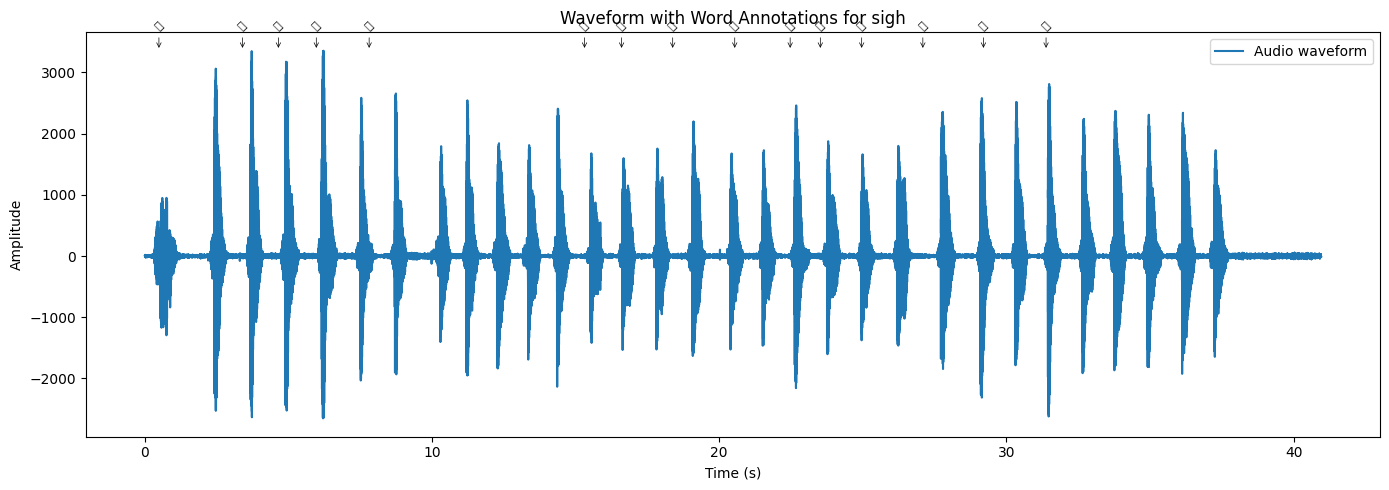


Processing dataset: sue
Word:  Siu, | Start: 30.00 s | End: 30.76 s
Word:  Siu, | Start: 30.76 s | End: 32.30 s
Word:  Siu, | Start: 32.30 s | End: 34.58 s
Word:  Siu, | Start: 34.58 s | End: 36.34 s
Word:  Siu, | Start: 36.46 s | End: 37.62 s
Word:  Siu, | Start: 37.62 s | End: 38.86 s
Word:  Siu, | Start: 38.86 s | End: 39.18 s
Word:  Siu. | Start: 39.18 s | End: 40.14 s


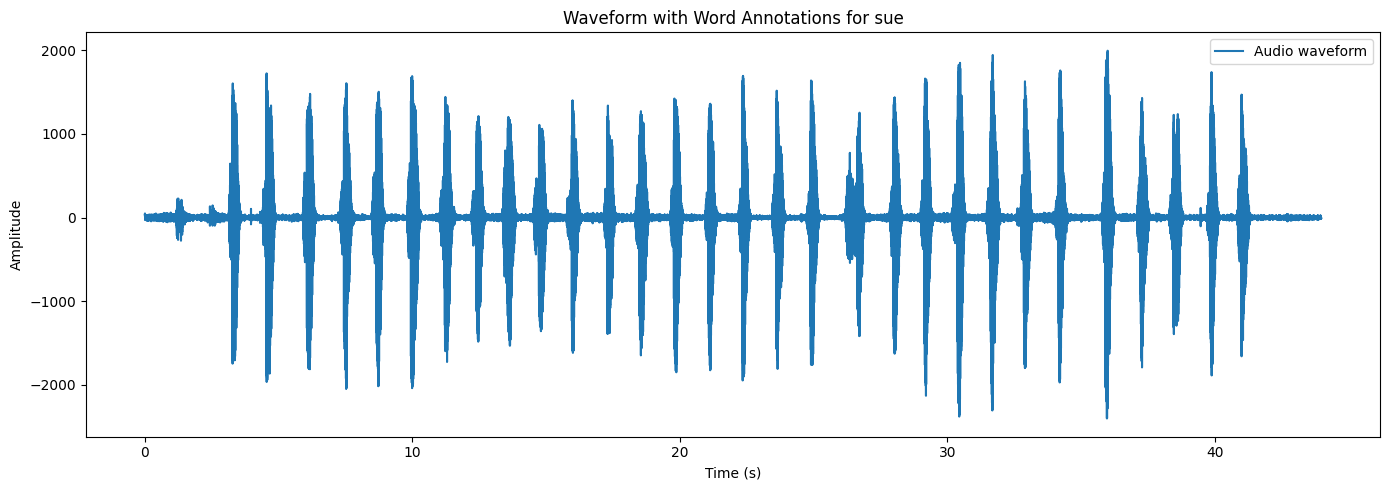


Processing dataset: they
Word:  They... | Start: 30.00 s | End: 31.34 s
Word:  they... | Start: 31.34 s | End: 32.80 s


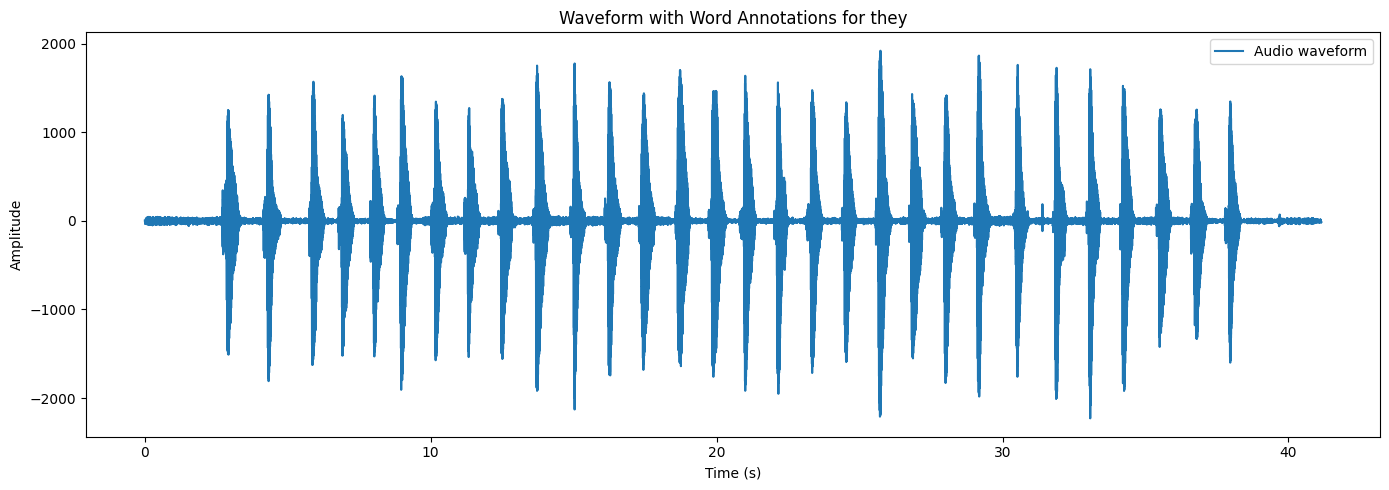


Processing dataset: us
Word:  Us | Start: 30.00 s | End: 30.34 s
Word:  Us | Start: 30.34 s | End: 31.78 s
Word:  Us | Start: 31.78 s | End: 33.64 s
Word:  Us | Start: 33.64 s | End: 35.46 s
Word:  Us | Start: 35.46 s | End: 36.78 s


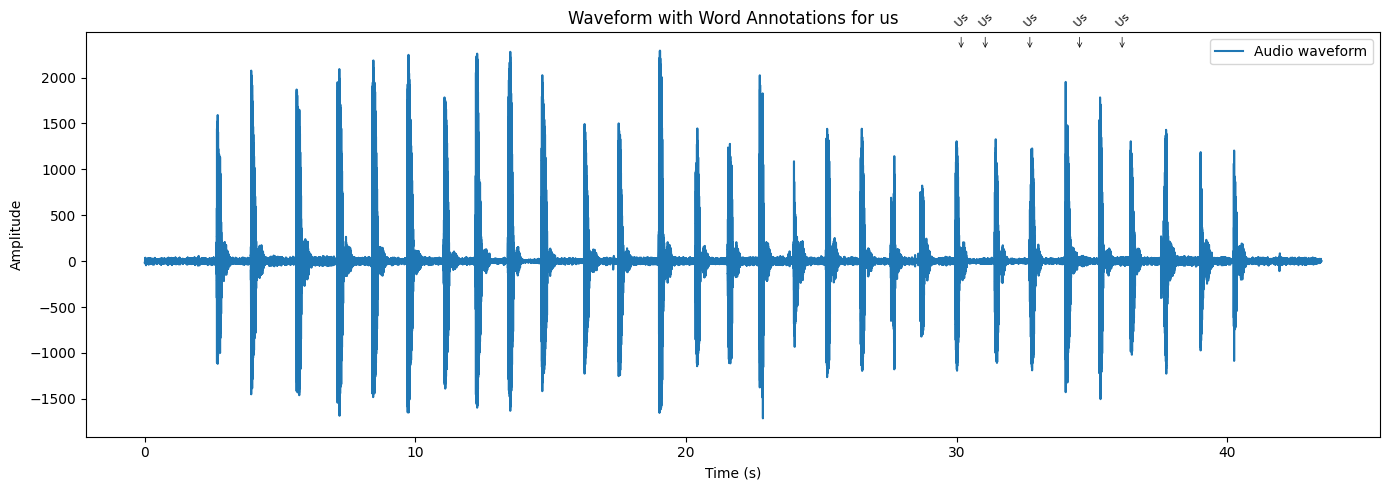


Processing dataset: vase
Word:  Vaze, | Start: 30.52 s | End: 31.44 s
Word:  vase, | Start: 31.94 s | End: 32.74 s
Word:  vase, | Start: 33.38 s | End: 34.16 s
Word:  vase, | Start: 34.94 s | End: 36.76 s
Word:  vase, | Start: 36.76 s | End: 38.56 s
Word:  vase, | Start: 38.56 s | End: 39.48 s
Word:  vase, | Start: 39.48 s | End: 40.88 s
Word:  vase, | Start: 40.88 s | End: 42.52 s
Word:  vase, | Start: 42.66 s | End: 44.28 s
Word:  vase, | Start: 44.28 s | End: 47.10 s
Word:  vase, | Start: 47.30 s | End: 48.02 s
Word:  vase, | Start: 48.02 s | End: 49.26 s
Word:  vase, | Start: 49.26 s | End: 49.68 s
Word:  vase, | Start: 50.06 s | End: 50.06 s
Word:  vase, | Start: 50.06 s | End: 50.60 s
Word:  vase, | Start: 50.60 s | End: 50.80 s
Word:  vase, | Start: 50.92 s | End: 51.02 s
Word:  vase, | Start: 51.02 s | End: 52.04 s
Word:  vase, | Start: 52.10 s | End: 52.10 s
Word:  vase, | Start: 52.10 s | End: 52.10 s
Word:  vase, | Start: 52.10 s | End: 52.10 s
Word:  vase, | Start: 52.88 s

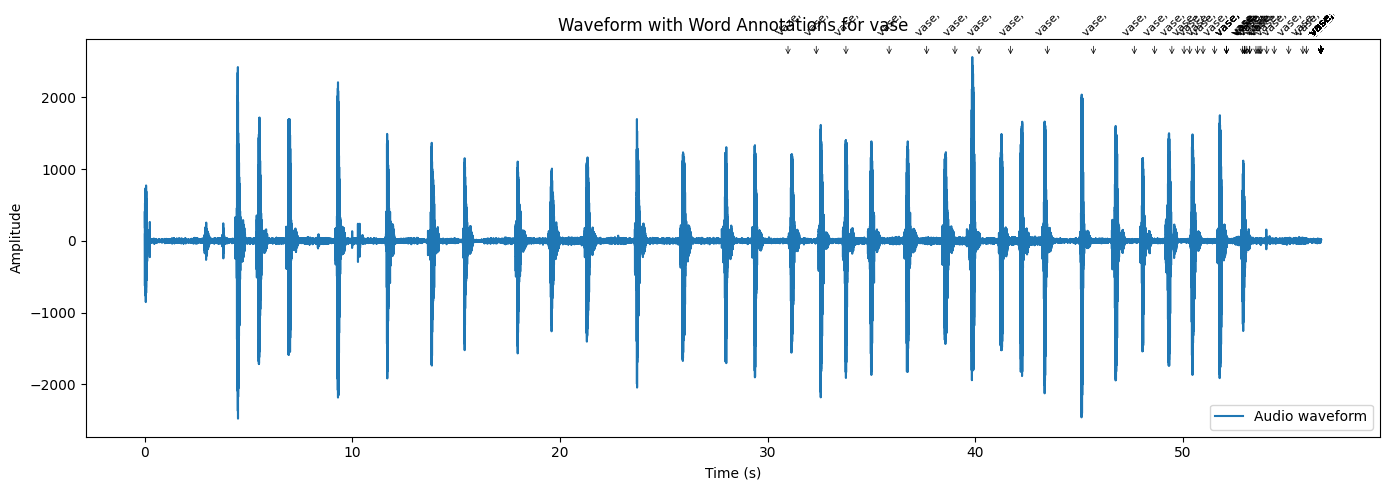


Processing dataset: wake
Word:  Wake. | Start: 30.00 s | End: 30.24 s
Word:  Wake. | Start: 30.88 s | End: 31.44 s
Word:  Wake. | Start: 32.52 s | End: 32.70 s
Word:  Wake. | Start: 33.62 s | End: 34.04 s
Word:  Wake. | Start: 34.74 s | End: 34.90 s
Word:  Wake. | Start: 35.72 s | End: 35.94 s
Word:  Wake. | Start: 36.94 s | End: 37.10 s
Word:  Wake. | Start: 38.04 s | End: 38.20 s
Word:  Wake. | Start: 38.32 s | End: 38.32 s
Word:  Wake. | Start: 38.64 s | End: 38.64 s


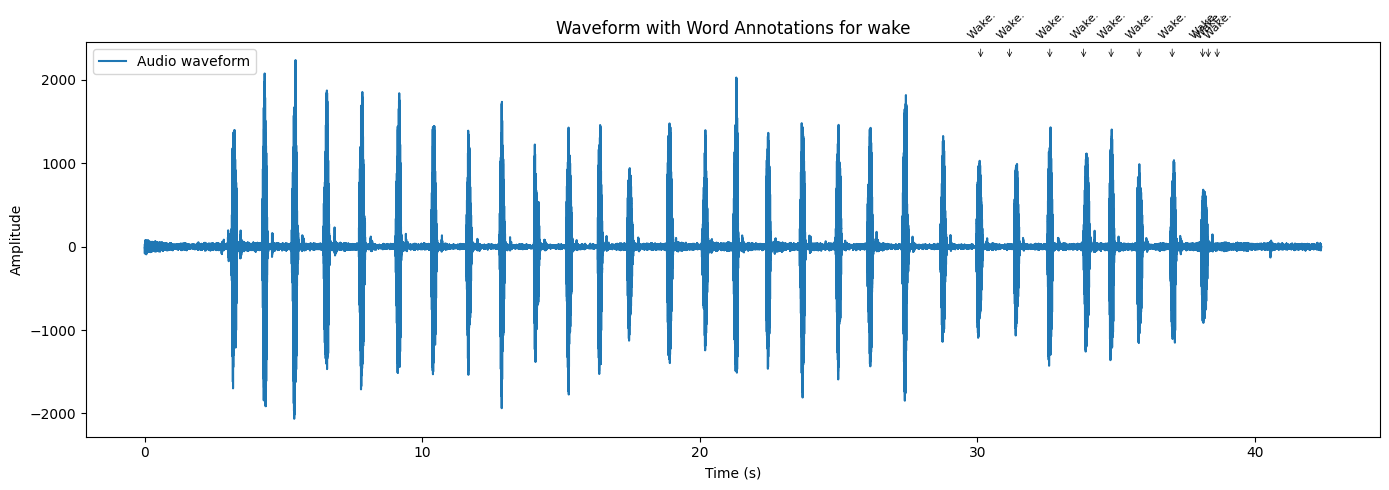


Processing dataset: wash
Word:  Wash, | Start: 30.00 s | End: 31.16 s
Word:  wash, | Start: 31.38 s | End: 32.06 s
Word:  wash, | Start: 32.70 s | End: 33.16 s
Word:  wash, | Start: 33.54 s | End: 34.14 s
Word:  wash, | Start: 34.14 s | End: 35.16 s
Word:  wash. | Start: 35.16 s | End: 37.10 s


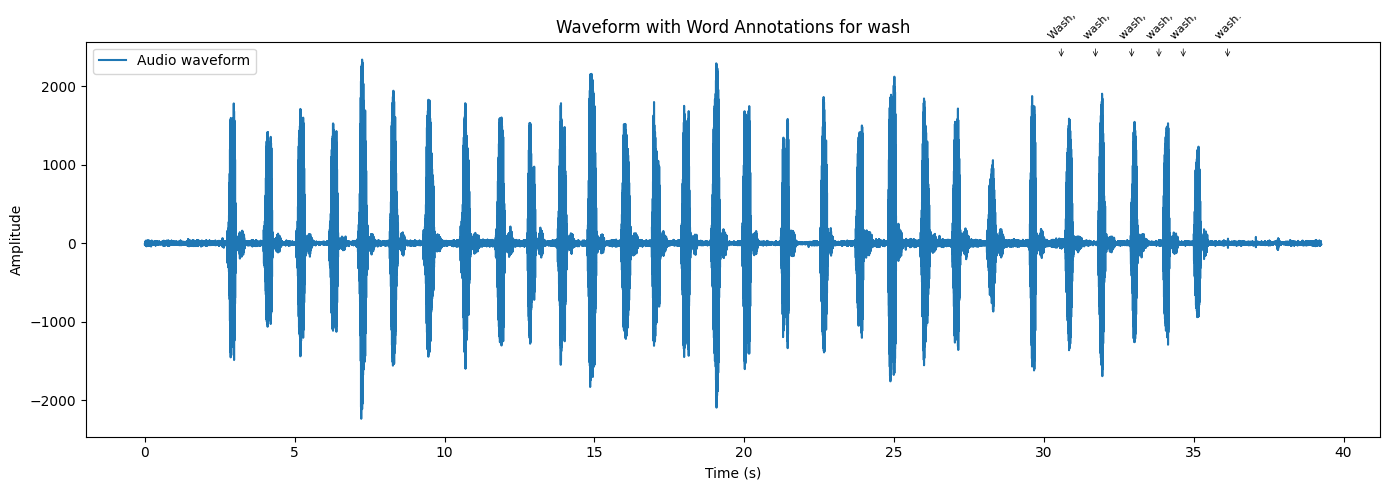


Processing dataset: way
Word:  way | Start: 30.00 s | End: 31.26 s
Word:  way | Start: 31.26 s | End: 32.64 s
Word:  way | Start: 32.64 s | End: 33.72 s
Word:  way | Start: 33.72 s | End: 34.90 s
Word:  way | Start: 34.90 s | End: 36.12 s
Word:  way | Start: 36.12 s | End: 37.20 s
Word:  way | Start: 37.20 s | End: 37.94 s
Word:  way | Start: 37.94 s | End: 38.36 s


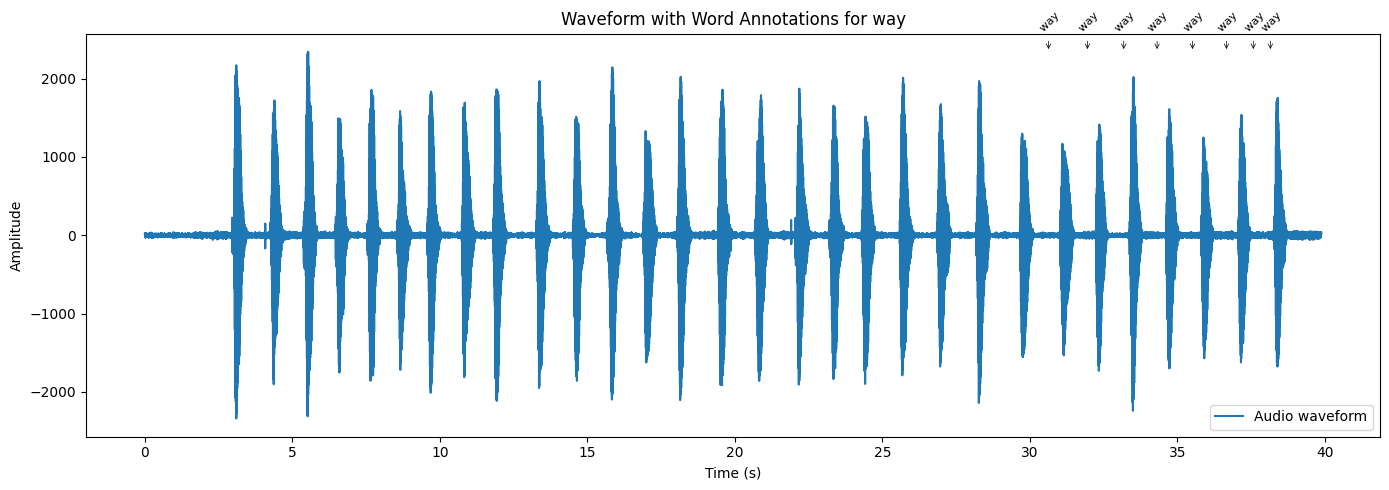


Processing dataset: weed
Word:  Weed, | Start: 2.54 s | End: 3.94 s
Word:  weed, | Start: 3.94 s | End: 5.34 s
Word:  weed, | Start: 5.34 s | End: 7.76 s
Word:  weed, | Start: 7.76 s | End: 8.90 s
Word:  weed, | Start: 8.90 s | End: 9.88 s
Word:  weed, | Start: 9.88 s | End: 11.04 s
Word:  weed, | Start: 11.04 s | End: 12.40 s
Word:  weed, | Start: 12.40 s | End: 13.52 s
Word:  weed, | Start: 13.52 s | End: 14.64 s
Word:  weed, | Start: 14.68 s | End: 16.28 s
Word:  weed, | Start: 16.28 s | End: 18.94 s
Word:  weed, | Start: 18.94 s | End: 20.12 s
Word:  weed, | Start: 20.12 s | End: 21.00 s


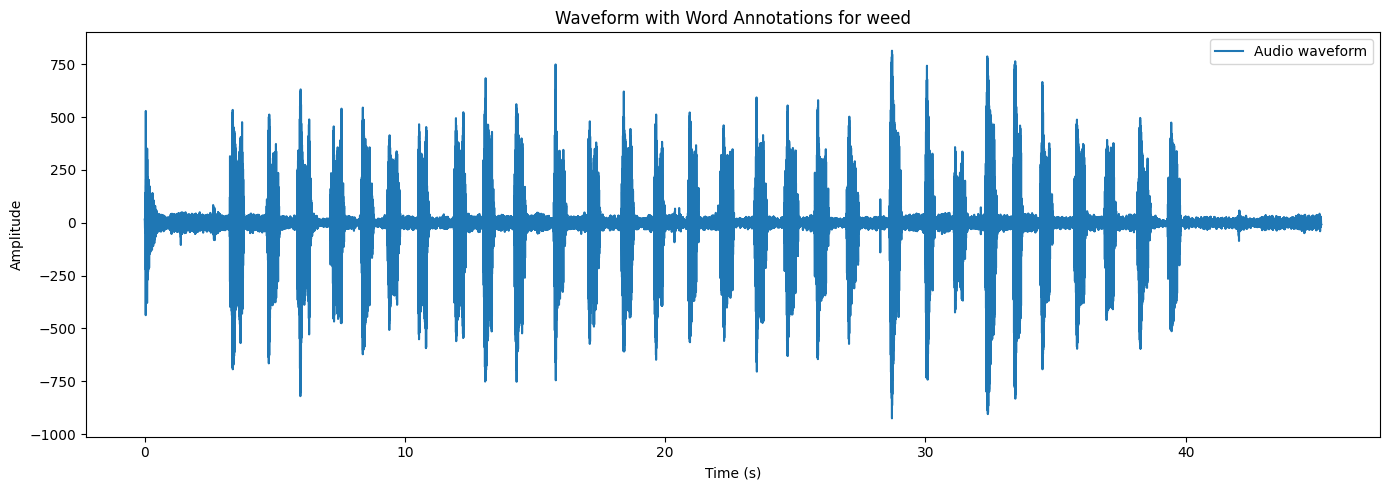


Processing dataset: why
Word:  Y | Start: 3.42 s | End: 3.86 s
Word:  Y | Start: 3.86 s | End: 4.30 s
Word:  Y | Start: 4.30 s | End: 5.58 s
Word:  Y | Start: 5.58 s | End: 6.78 s
Word:  Y | Start: 6.78 s | End: 7.96 s
Word:  Y | Start: 7.96 s | End: 9.14 s
Word:  Y | Start: 9.14 s | End: 10.30 s
Word:  Y | Start: 10.30 s | End: 10.74 s
Word:  Y | Start: 10.74 s | End: 11.72 s
Word:  Y | Start: 11.72 s | End: 12.50 s
Word:  Y | Start: 12.50 s | End: 19.90 s
Word:  Y | Start: 19.90 s | End: 20.12 s
Word:  Y | Start: 20.12 s | End: 20.60 s
Word:  Y | Start: 20.60 s | End: 21.22 s
Word:  Y | Start: 21.22 s | End: 21.44 s
Word:  Y | Start: 21.44 s | End: 21.74 s
Word:  Y | Start: 21.74 s | End: 22.48 s
Word:  Y | Start: 22.48 s | End: 22.64 s
Word:  Y | Start: 22.64 s | End: 22.82 s
Word:  Y | Start: 22.82 s | End: 22.98 s
Word:  Y | Start: 22.98 s | End: 23.40 s
Word:  Y | Start: 23.40 s | End: 23.86 s
Word:  Y | Start: 23.86 s | End: 24.00 s
Word:  Y | Start: 24.00 s | End: 24.20 s
Word

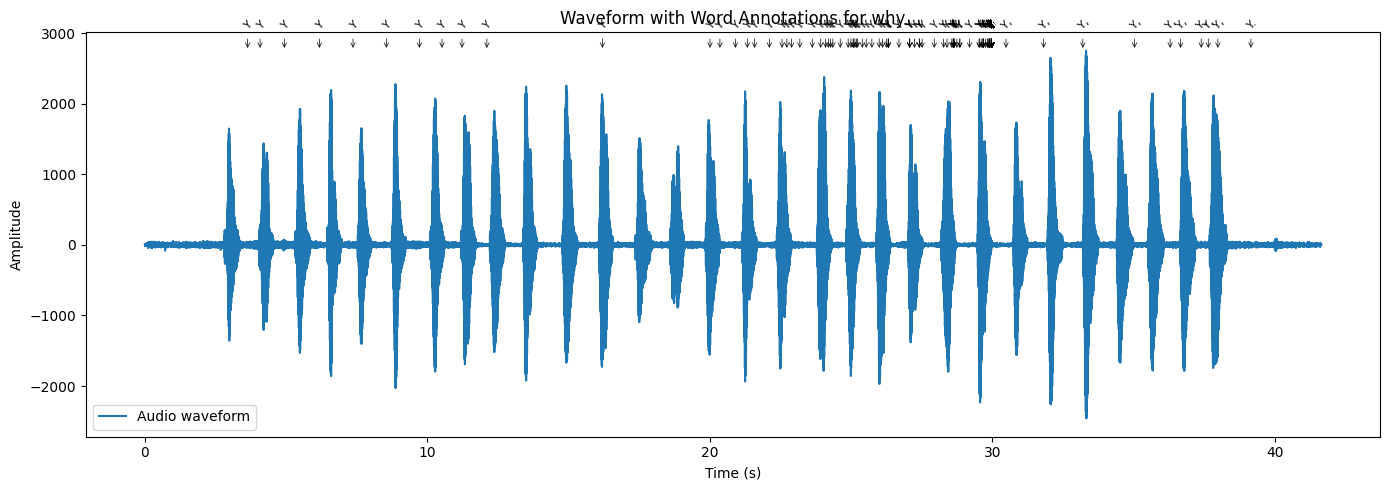


Processing dataset: woo
Word:  Well, | Start: 2.26 s | End: 2.94 s
Word:  well, | Start: 3.60 s | End: 4.08 s
Word:  well, | Start: 5.04 s | End: 5.36 s
Word:  well, | Start: 5.86 s | End: 6.50 s
Word:  well, | Start: 7.38 s | End: 8.64 s
Word:  well, | Start: 8.94 s | End: 9.72 s
Word:  well, | Start: 9.72 s | End: 10.22 s
Word:  well, | Start: 10.56 s | End: 11.62 s
Word:  well, | Start: 11.70 s | End: 12.24 s
Word:  well, | Start: 12.24 s | End: 13.08 s
Word:  well, | Start: 13.28 s | End: 13.50 s
Word:  well, | Start: 13.50 s | End: 14.24 s
Word:  well, | Start: 14.58 s | End: 15.60 s
Word:  well, | Start: 15.84 s | End: 16.78 s
Word:  well, | Start: 17.30 s | End: 18.02 s
Word:  well, | Start: 18.28 s | End: 20.56 s
Word:  well, | Start: 20.70 s | End: 21.24 s
Word:  well, | Start: 21.24 s | End: 21.96 s
Word:  well, | Start: 22.16 s | End: 22.22 s
Word:  well, | Start: 22.22 s | End: 23.28 s
Word:  well, | Start: 23.28 s | End: 23.44 s
Word:  well, | Start: 23.52 s | End: 23.52 

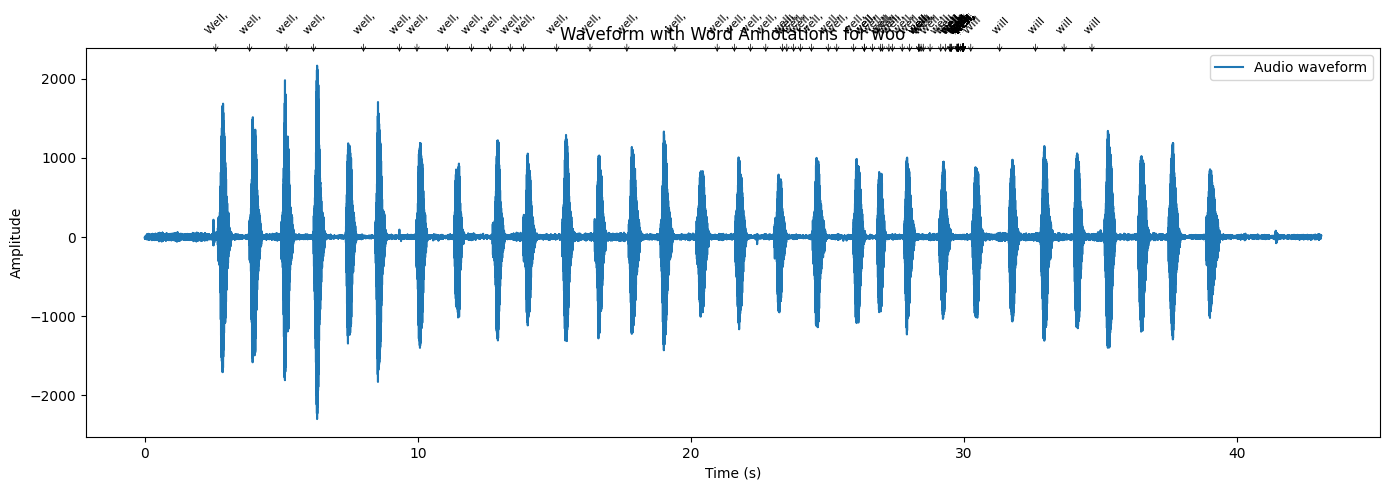

In [ ]:
import os
import tempfile
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import torch

# Import the faster-whisper model.
from faster_whisper import WhisperModel

datasets = loader.list_datasets()
print("Available datasets:", datasets)

# Load the Whisper model using faster-whisper. Choose your device accordingly.
device = "cuda" if torch.cuda.is_available() else "cpu"
model = WhisperModel("base", device=device)

# Process each dataset
for ds in datasets:
    print(f"\nProcessing dataset: {ds}")
    data = loader.load_dataset(ds)
    audio_data = data["audio_data"]  # Assuming a 1-D numpy array of samples

    # Save the audio to a temporary WAV file
    with tempfile.NamedTemporaryFile(suffix=".wav", delete=False) as tmp:
        tmp_file = tmp.name
        sf.write(tmp_file, audio_data, AUDIO_SAMPLE_RATE)

    # Use faster-whisper to transcribe the audio with word timestamps.
    # The 'transcribe' function returns segments as objects with attributes (including .words).
    segments, info = model.transcribe(tmp_file, beam_size=5, word_timestamps=True)

    # Gather word-level information across segments
    words_list = []
    for segment in segments:
        if hasattr(segment, "words") and segment.words is not None:
            words_list.extend(segment.words)

    # Print the word and timestamp information for verification
    for w in words_list:
        print(f"Word: {w.word} | Start: {w.start:.2f} s | End: {w.end:.2f} s")

    # Plot the audio waveform with word annotations.
    # Create a time axis in seconds.
    time_axis = np.linspace(0, len(audio_data) / AUDIO_SAMPLE_RATE, num=len(audio_data))
    plt.figure(figsize=(14, 5))
    plt.plot(time_axis, audio_data, label="Audio waveform")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.title(f"Waveform with Word Annotations for {ds}")

    # Determine a vertical offset for annotations.
    max_amp = np.max(np.abs(audio_data))
    y_offset = max_amp * 0.1  # adjust as needed

    # Annotate each word: placing the text at the midpoint of the word duration.
    for w in words_list:
        mid_time = (w.start + w.end) / 2
        plt.annotate(
            w.word,
            xy=(mid_time, max_amp),
            xytext=(mid_time, max_amp + y_offset),
            arrowprops=dict(facecolor='black', arrowstyle="->", lw=0.5),
            horizontalalignment='center',
            fontsize=8,
            rotation=45
        )

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Clean up the temporary file.
    os.remove(tmp_file)
